In [1]:
def clearall():
    all = [var for var in globals() if var[0] != "_"]
    for var in all:
        del globals()[var]
clearall()

In [2]:
############################
######## LIBRAIRIES ########
############################
print('Importing Librairies...')
from sklearn.linear_model import LinearRegression
from colorama import Fore, Back, Style
from statsmodels.tsa.vector_ar.vecm import coint_johansen as johasen
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.decomposition import PCA
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import sklearn.preprocessing
from statsmodels.tsa.stattools import adfuller
from colorama import Fore, Back, Style
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import time
import os
import datetime as dt
import numpy as np
import fxcmpy
import itertools
import shelve
import ppscore as pps
from twilio.rest import Client
import pyttsx3
engine = pyttsx3.init()
print('Librairies imported\n')
print('version fxcmpy :',fxcmpy.__version__)
%matplotlib inline
plt.style.use('seaborn')
engine.say("librairie loaded")
engine.runAndWait()
#ignore by message
import warnings
warnings.filterwarnings("ignore", message="A value is trying to be set on a copy of a slice from a DataFrame.")
warnings.filterwarnings("ignore", message="Try using .loc[row_indexer,col_indexer] = value instead")
warnings.filterwarnings("ignore", message="The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.")
warnings.filterwarnings("ignore", message="The inverse of the variance-covariance matrix ")
print('Prêt')

Importing Librairies...
Librairies imported

version fxcmpy : 1.2.6
Prêt


In [3]:
##############################################
######## INITIALISATION DES VARIABLES ########
##############################################

engine.say("Ignition du Lumberjack")
engine.runAndWait() 

# COMPTE DEV #
TOKEN = '79f83cbff13d296eb6d9b6c1ed6dccd768ef925a'
server = 'demo'
user_id = 'D261219577'
compte = '01215060'
password = '3877'

period = 'm5'
number = 10000 # Nombre de periodes pour l'historique
invers = 'non'
train_length = 5780 # Longueur du training
nb_pattes = 3
target = 800
coef_lim = 6 # Pour définir par combien on divise l'amplitude pour définir les limites

debut = dt.date(1,1,1)
fin = dt.date(1,1,1)
split = dt.date(1,1,1)

lim_s1 = 0
lim_s2 = 0
lim_s3 = 0
lim_l1 = 0
lim_l2 = 0
lim_l3 = 0
lim_cs = -0.13
lim_cl = 0.13

CSTE = []
PAIR = []
S = []
SL_PACK = []

D = {}

print('\nSauvegarde du ficher Log\n')
d = shelve.open('BT_varlog'+compte)
d['D'] = D 
d.close()

engine.say("בסדר")
engine.runAndWait()
print('Ok')


Sauvegarde du ficher Log

Ok


In [4]:
############################
######## FONCTIONS ########
###########################

def conX():
    con = fxcmpy.fxcmpy(access_token=TOKEN, log_level='error',server=server)
    if con.is_connected() == True:
        print(Fore.GREEN+'Connexion établie'+Style.RESET_ALL)
        print('Compte utilisé : ',con.get_account_ids())
    else:
        print(Fore.RED+'Connexion non établie'+Style.RESET_ALL)
    return(con)

def deconX():
    con = con.close()
    if con.is_connected() == True:
        print(Fore.GREEN+'Connexion non intérrompue'+Style.RESET_ALL)
        print('Compte utilisé : ',con.get_account_ids())
    else:
        print(Fore.RED+'Connexion intérrompue'+Style.RESET_ALL)
    return()

def remove_index(INDEX): 
    for key,val in D.items():
        exec(key + '=val')
    for x in range(big_len):
        for ind in INDEX:
            if ind not in (globals()['uni_df%s' % x]).index :
                INDEX.remove(ind)
    return(INDEX)

def clean_index(df):
    for key,val in D.items():
        exec(key + '=val')
    I = []
    for i in range(0,len(df)):
        if df.index[i] not in INDEX:
            I.append(i)
    df = df.drop(df.index[I])
    return(df)


def scrap_hist(ticker,invers = 'non'):
    data = con.get_candles(ticker,period=period,number=number)
    df = pd.DataFrame(index=data.index)
    df['Open'] = (data['bidopen']+data['askopen'])/2
    df['High'] = (data['bidhigh']+data['askhigh'])/2
    df['Low'] = (data['bidlow']+data['asklow'])/2
    df['Close'] = (data['bidclose']+data['askclose'])/2
    if invers == 'oui':
        df['Open'] = 1 / df['Open']
        df['High'] = 1 / df['High']
        df['Low'] = 1 / df['Low']
        df['Close'] = 1 / df['Close']
    return(df)


def ols(model,results,residuals):
    jb = sm.stats.stattools.jarque_bera(residuals)[0]
    p_value = sm.stats.stattools.jarque_bera(residuals)[1]
    skew = round(sm.stats.stattools.robust_skewness(residuals)[0],4)
    kurtosis = round(sm.stats.stattools.robust_kurtosis(residuals)[0],4)
    durbinwatson = sm.stats.stattools.durbin_watson(residuals, axis=0)
    return(jb,p_value,skew,kurtosis,durbinwatson)

def ols_diff(diff):
    model_diff = sm.OLS(diff[1:],df.index[1:])
    results_diff = model_diff.fit()
    residuals_diff = results_diff.resid
    summary_diff = results_diff.summary()
    jb_diff = sm.stats.stattools.jarque_bera(residuals_diff)[0]
    p_value_diff = sm.stats.stattools.jarque_bera(residuals_diff)[1]
    skew_diff = round(sm.stats.stattools.robust_skewness(residuals_diff)[0],4)
    kurtosis_diff = round(sm.stats.stattools.robust_kurtosis(residuals_diff)[0],4)
    durbinwatson_diff = sm.stats.stattools.durbin_watson(residuals_diff, axis=0)
    return(jb_diff,p_value_diff,skew_diff,kurtosis_diff,durbinwatson_diff)

def jarque_berra(df):
    if p_value <= 0.05:
        stop = 0
    else:
        stop = 1
    return(stop)

def skewness(df):
    if skew < -0.1 or skew > 0.1:
        stop = 0
    else:
        stop = 1
    return(stop)

def kurtos(df):
    if kurtosis > -3.1 or kurtosis < 3.1:
        stop = 0
    else:
        stop = 1
    return(stop)

def autocor(df):
    autocorell = pd.DataFrame()
    autocorell['ACF'] = sm.tsa.stattools.acf(df['Close'],qstat=True,fft=False)[0]
    autocorell['PACF'] = sm.tsa.stattools.pacf(df['Close'])
    QSTAT = list(sm.tsa.stattools.acf(df['Close'],qstat=True,fft=False)[1])
    QSTAT.append(df.iloc[-1]['Close'])
    PROB = list(sm.tsa.stattools.acf(df['Close'],qstat=True,alpha=0.05,fft=False)[3])
    PROB.append(0.5)
    autocorell['QSTAT'] = QSTAT
    autocorell['PROB'] = PROB
    index = 0
    for i in range(len(autocorell)-1):
        if autocorell.iloc[i]['PACF']>autocorell.iloc[i]['PROB']+0.1:
            index += 1
    if index >= 1:
        stop = 0
    else:
        stop = 1
    return(stop)

def autocor_diff(diff):
    autocorell = pd.DataFrame()
    autocorell['ACF'] = sm.tsa.stattools.acf(diff,qstat=True,fft=False)[0]
    autocorell['PACF'] = sm.tsa.stattools.pacf(diff)
    QSTAT = list(sm.tsa.stattools.acf(diff,qstat=True)[1],fft=False)
    QSTAT.append(0)
    PROB = list(sm.tsa.stattools.acf(diff,qstat=True,alpha=0.05)[3],fft=False)
    PROB.append(0.5)
    autocorell['QSTAT'] = QSTAT
    autocorell['PROB'] = PROB
    index = 0
    for i in range(len(autocorell)-1):
        if autocorell.iloc[i]['PACF']>autocorell.iloc[i]['PROB']+0.1:
            index += 1
    if index >= 1:
        p = 1
    else:
        stop = 1
    return()

def test_stationarity(timeseries,lag):
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    dftest = adfuller(timeseries, autolag=None,maxlag=lag )#'AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return(dfoutput)

def test_adf(df):
    X = df['Close'].values
    result_adf = adfuller(X)
    
    for key, value in result_adf[4].items():
        print('\t%s: %.3f' % (key, value))

    if result_adf[1] >= 0.05:
        stop = 1
    else:
        stop = 0
        
    X = diff[1:].values
    result_adf = adfuller(X)
    
    if result_adf[1] >= 0.05 :
        stop = 1

    elif result_adf[0] >= min([result_adf[4]['1%'],result_adf[4]['5%'],result_adf[4]['10%']]):
        stop = 1

    else:
        stop = 0
    return(stop)

def train(D):
    global p_value,ev,v,v1,v2,jh_results,skew,kurtosis
    break_it = 0
    stop = 0
    full_stop = 1

    p_value = 0
    ev = 0
    v = 0
    jh_results = 0
    v1 = 0
    v2 = 0
    skew = 0
    kurtosis = 0
    full_stop = 0
    residu = 0
    nbposs = 0
    nbposl = 0
    nbpos = 0
    nbre_trade = 0
    nbre_trade_long = 0
    nbre_trade_short = 0
    pnll = 0
    pnls = 0
    for key,val in D.items():
        exec(key + '=val')
    
    print(Style.RESET_ALL,'')
    #debut = TIME_FRAME[-diloug]
    debut = total_TIME_FRAME[0]
    split = total_TIME_FRAME[train_length] # ?? A tej ??
    fin = total_TIME_FRAME[train_length]
    print(Fore.MAGENTA,'')
    print('|||| TIME_FRAME <---> debut :',debut,' <---> fin : ',fin) # TIME_FRAME[-diloug]
    print(Style.RESET_ALL)
    D['debut'] = debut
    D['split'] = split
    D['fin'] = fin
    for key,val in D.items():
        exec(key + '=val')
    
    PAIR = []
    for x in range(nb_pattes):
        globals()['pair%s' % x] = globals()['base_pair%s' % x][(globals()['base_pair%s' % x].index >= debut)&(globals()['base_pair%s' % x].index <= split)]
        globals()['pair%s' % x]['Local time'] = globals()['pair%s' % x].index
        globals()['pair%s' % x].reset_index(drop=True, inplace=True)
        D['pair%s' % x] = globals()['pair%s' % x]
        print('Récupération pair%s => ' % x,globals()['pair%s' % x].shape)
        print('Dernière valeur des pairs :',globals()['pair%s' % x].iloc[-1]['Close'])
        PAIR.append(globals()['pair%s' % x])
    
    D['PAIR'] = PAIR
    
    for key,val in D.items():
        exec(key + '=val')
    print('Longueur de PAIR [liste des pairs]', len(PAIR))

    for pair in PAIR:
        for x in range(nb_pattes):
            if pair.equals(globals()['pair%s' % x]):
                name = TICKERS[x]
        print('Passage pour',name)
        model = sm.OLS(pair['Close'],pair.index)
        results = model.fit()
        residuals = results.resid
        summary = results.summary()

        jb,p_value,skew,kurtosis,durbinwatson = ols(model,results, residuals)

        jarque_berra(pair)
        skewness(pair)
        kurtos(pair)
        autocor(pair)

    ####################
    daf = pd.DataFrame()
    ####################

    for pair in PAIR:
        for x in range(nb_pattes):
            if pair.equals(globals()['pair%s' % x]):
                name = TICKERS[x]
                print('Dernière valeur de',TICKERS[x],' :',globals()['pair%s' % x].iloc[-1]['Close'])
        daf[name] = list(pair['Close'])
    daf.corr().style.background_gradient(cmap='coolwarm')
    
    D['daf'] = daf
    for key,val in D.items():
        exec(key + '=val')
    
    INTEGRE = []
    for col in range(1,len(daf.corr())):
        for ind in range(col):
            if daf.corr().iloc[ind,col] > 0.5 and daf.corr().iloc[ind,col] != 1:
                INTEGRE.append((daf.corr().index[ind],daf.corr().columns[col]))

    INTEGRE  = list(set(INTEGRE))
    D['INTEGRE'] = INTEGRE
    for key,val in D.items():
        exec(key + '=val')
    kmo_all,kmo_model=calculate_kmo(daf)

    for loop,pair in enumerate(PAIR):
        for x in range(nb_pattes):
            if pair.equals(globals()['pair%s' % x]):
                name = TICKERS[x]
        if kmo_all[loop] >= 0.6:
            print(Fore.GREEN,name,Style.RESET_ALL,' a un kmo considéré comme ',Fore.GREEN,'adéquat',Style.RESET_ALL)
        else:
            print(Fore.RED,name,Style.RESET_ALL,' a un kmo donsidéré comme ',Fore.RED,'inadéquat',Style.RESET_ALL)
            break_it = 1

    chi_square_value,p_value=calculate_bartlett_sphericity(daf)
    if p_value < 0.05:
        stop = 0
    else:
        stop = 1
        if nbposs == 0 and nbposl == 0 : 
            #continue
            print(Back.WHITE,Fore.CYAN,'\n\n\nLIGNE 434\n\n\n',Style.RESET_ALL)

    fa = FactorAnalyzer(rotation=None)
    fa.fit(daf)

    ev, v = fa.get_eigenvalues()

    PRINCIPAL_COMPOSANT = []
    for loop,pair in enumerate(PAIR):
        for x in range(nb_pattes):
            if pair.equals(globals()['pair%s' % x]):
                name = TICKERS[x]
        if ev[loop] >= 1:
            PRINCIPAL_COMPOSANT.append((name,ev[loop]))

    jh_results = johasen(daf,0,1)
    v1 = jh_results.evec[:, 0]
    v2 = jh_results.evec[:, 1]
    if jh_results.eig[0] <= 0.05:
        stop = 0
    else:
        stop = 1
        if nbposs == 0 and nbposl == 0 : 
            #continue
            print(Back.WHITE,Fore.CYAN,'\n\n\nLIGNE 456\n\n\n',Style.RESET_ALL)
    
    X = daf.iloc[:,1:]
    y = daf.iloc[:,0]
    reg = LinearRegression().fit(X, y)
    score = reg.score(X, y) *100
    coef = reg.coef_
    cste = reg.intercept_
    CSTE.append(cste)

    D['coef'] = coef
    D['cste'] = cste
    D['CSTE'] = CSTE
    for key,val in D.items():
        exec(key + '=val')
    
    if score > 70:
        print('SCORE > 70')
        stop = 0
        for loop,pair in enumerate (PAIR):
            for x in range(nb_pattes):
                if pair.equals(globals()['pair%s' % x]):
                    name = TICKERS[x]
            if loop == 0:
                #continue
                print('Paire principale :',name)
            #loop += 1
            else:
                try:
                    print(name,' - coef : ',coef[loop-1]) 
                except:
                    print('Problème calculationique Sam R')
                    stop = 1
                    if nbposs == 0 and nbposl == 0 : 
                        continue
                        print(Back.WHITE,Fore.CYAN,'\n\n\nLIGNE 481\n\n\n',Style.RESET_ALL)
                           
    elif score > 50:
        print('SCORE > 50')
        loop = 0
        for pair in PAIR:
            for x in range(nb_pattes):
                if pair.equals(globals()['pair%s' % x]):
                    name = TICKERS[x]
            if name == TICKERS[0]:
                continue
            loop += 1
            try:
                print(name,' : ',coef[loop])
            except:
                stop = 1
                if nbposs == 0 and nbposl == 0 : 
                    continue
                    print(Back.WHITE,Fore.CYAN,'\n\n\nLIGNE 497\n\n\n',Style.RESET_ALL)

    else:
        print('SCORE < 50')
        stop = 1
        loop = 0
        for pair in PAIR:
            for x in range(nb_pattes):
                if pair.equals(globals()['pair%s' % x]):
                    name = TICKERS[x]
            if name == TICKERS[0]:
                continue
            loop += 1
            try:
                print(name,' : ',coef[loop])
            except:
                stop = 1
                if nbposs == 0 and nbposl == 0 : 
                    print(Back.WHITE,Fore.CYAN,'\n\n\nLIGNE 512\n\n\n',Style.RESET_ALL)
                    continue

    if nb_pattes == 2:
        combo = coef[0] * daf[TICKERS[1]] + cste
    elif nb_pattes == 3:
        combo = coef[0] * daf[TICKERS[1]] + coef[1] * daf[TICKERS[2]] + cste
    elif nb_pattes == 4:
        combo = coef[0] * daf[TICKERS[1]] + coef[1] * daf[TICKERS[2]] + coef[2] * daf[TICKERS[3]] + cste
    elif nb_pattes == 5:
        combo = coef[0] * daf[TICKERS[1]] + coef[1] * daf[TICKERS[2]] + coef[2] * daf[TICKERS[3]] + coef[3] * daf[TICKERS[4]] + cste
    
    print('TICKERS : ',TICKERS)
    print('COEF',coef)
    print('CSTE',cste)
    print('Dernière valeur du combo à ',combo.iloc[-1])
    ########
    ### RESIDUS
    ########
    residu = daf[TICKERS[0]] - combo
    print('Derniere valeur du residu',residu.iloc[-1])
    S = (residu - residu.mean())/residu.std()
    print('Dernière valeur du Score >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>',S.iloc[-1],'<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<')
    _mean = residu.mean()
    print('Mean',_mean)
    _std = residu.std()
    print('Std',_std)

    D['_mean'] = _mean
    D['_std'] = _std
    D['S'] = S
    D['coef'] = coef
    D['residu'] = residu 
    D['combo'] = combo
    for key,val in D.items():
        exec(key + '=val')

    print(' Pour les TICKERS :',TICKERS,', - Moyenne du spread :',_mean,' - Std Dev du spread : ',_std)
    print('La déviation est de :',abs(S.iloc[-1])-S.mean())
    
    ####
    ## ANALYSE DES RESIDUS
    ###

    jarque_berra(residu)
    skewness(residu)
    kurtos(residu)
    residu_autocor = pd.DataFrame()
    residu_autocor['Close'] = residu.iloc[:]
    autocor(residu_autocor)

    model = sm.OLS(residu,residu.index)
    results = model.fit()
    residuals = results.resid
    summary = results.summary()
    name = 'Analyse des Résidus'
    jb,p_value,skew,kurtosis,durbinwatson = ols(model,results, residuals)

    dfoutput =  test_stationarity(residu,lag = 1)
    
    if dfoutput[1] < 0.05 and dfoutput[0] < dfoutput[6]:
        print('Le test est ',Fore.GREEN,'VALIDE',Style.RESET_ALL,'et le résidu est : ',Fore.GREEN,'STATIONNAIRE',Style.RESET_ALL)
        stop = 0
    
    else:
        print('Le test est ',Fore.RED,'NON VALIDE',Style.RESET_ALL,'et le résidu  : ',Fore.RED,'NON STATIONNAIRE',Style.RESET_ALL)
        stop = 1
        if nbposs == 0 and nbposl == 0 : 
            print(Back.WHITE,Fore.CYAN,'\n\n\nLIGNE 550\n\n\n',Style.RESET_ALL)

    #######
    ### RETOUR A LA MOYENNE
    #######
    dfoutput =  test_stationarity(residu,lag = 0)

    if dfoutput[1] < 0.05 and dfoutput[0] < dfoutput[6]:
        print('Le test est ',Fore.GREEN,'VALIDE',Style.RESET_ALL,'et il y a : ',Fore.GREEN,'RETOUR A LA MOYENNE',Style.RESET_ALL)
        _retmoy1 = dfoutput[1]
        _retmoy6 = dfoutput[6]
        # stop = 0 # => On veut que tout soit validé avant. Donc pas de stop à 0 ici
    
    else:
        print('Le test est ',Fore.RED,'NON VALIDE',Style.RESET_ALL,"et il n'y a ",Fore.RED,'PAS RETOUR A LA MOYENNE',Style.RESET_ALL)
        stop = 1
        if nbposs == 0 and nbposl == 0 : 
            print(Back.WHITE,Fore.CYAN,'\n\n\nLIGNE 565\n\n\n',Style.RESET_ALL)


    chi_square_value,p_value=calculate_bartlett_sphericity(daf)
    
    if p_value < 0.05:
        print(Fore.GREEN,'Statistically significant',Style.RESET_ALL," ce qui signifie que la matrice de correlation observée n'est pas une identity matrix" )
    
    else:
        print(Fore.RED,'Statistically non significant',Style.RESET_ALL," ce qui signifie que la matrice de correlation observée peut être une identity matrix" )

    fa = FactorAnalyzer(rotation=None)
    fa.fit(daf)

    ev, v = fa.get_eigenvalues()

    pca = PCA(n_components=2)
    pca.fit(daf)

    x_pca = pca.transform(daf)
    x_pca.shape


    for loop,pair in enumerate(PAIR):
        for x in range(nb_pattes):
            if pair.equals(globals()['pair%s' % x]):
                name = TICKERS[x]

    jh_results = johasen(daf,0,1)

    v1 = jh_results.evec[:, 0]
    v2 = jh_results.evec[:, 1]

    if jh_results.eig[0] <= 0.05:
        print('\nTest de cointiégration de Johasen ',Fore.GREEN,'VALIDE!',Style.RESET_ALL)
    
    else:
        print('\nTest de cointiégration de Johasen',Fore.RED,'INVALIDE!',Style.RESET_ALL)
    
    print('\nTEST DU FULL STOP - et stop à ',stop,' - ','\n')
    
    if stop == 0 and break_it != 1:
        print('\nFull Stop à 0\n')
        engine.say("בול! מצוין! הודו להשם כי טוב!")
        engine.runAndWait()
        full_stop = 0
        print('Trader, trader, pour information, la constante vaut ',cste)
        print(Back.LIGHTBLUE_EX,Fore.YELLOW,' P A C K     V A L I D E     = >      S L _ P A C K ',Style.RESET_ALL)
        try:
            amplitude = round(max(S),4) - round(min(S),4)
        except:
            amplitude = 0

        lim_s1 = amplitude/coef_lim * 1
        lim_s2 = amplitude/coef_lim * 2
        lim_s3 = amplitude/coef_lim * 3
        lim_l1 = -amplitude/coef_lim * 1
        lim_l2 = -amplitude/coef_lim * 2
        lim_l3 = -amplitude/coef_lim * 3

        _up1 = len([x for x in S.to_list() if x > lim_s1 and x < lim_s2])
        _up2 = len([x for x in S.to_list() if x > lim_s2 and x < lim_s3])
        _down1 = len([x for x in S.to_list() if x < lim_l1 and x > lim_l2])
        _down2 = len([x for x in S.to_list() if x < lim_l2 and x > lim_l3])

        if _down1 == 0:
            _down1 = 0.1
        if _down2 == 0:
            _down2 = 0.1
        if _up1 == 0:
            _up1 = 0.1
        if _up2 == 0:
            _up2 = 0.1

        _ratio1 = round((_up1/_down1) * 100,0) # 80 - 120
        _ratio2 = round((_up2/_down2) * 100,0) # 80 - 120
        _ratio_cross = round(((_up2+_down2)/(_up1+_down1) * 100),0) # > 50
        _freq1 = ((_up1+_down1)/len(S)) * 100
        _freq2 = ((_up2+_down2)/len(S)) * 100
        
        D['lim_s1'] = lim_s1
        D['lim_s2'] = lim_s2
        D['lim_s3'] = lim_s3
        D['lim_l1'] = lim_l1
        D['lim_l2'] = lim_l2
        D['lim_l3'] = lim_l3
        D['_ratio1'] = _ratio1
        D['_ratio2'] = _ratio2
        D['_ratio_cross'] = _ratio_cross
        D['_freq1'] = _freq1
        D['_freq2'] = _freq2
        D['amplitude'] = amplitude
        
        ########################################################################################################################################
        SL_PACK.append([TICKERS,_mean,_std,S,coef,residu,combo,daf,cste,lim_s1,lim_s2,lim_s3,lim_l1,lim_l2,lim_l3,_ratio1,_ratio2,_ratio_cross,\
        _freq1,_freq2,amplitude])
        ########################################################################################################################################

        print(Fore.CYAN,'VERIFICATION DE LA LONGUEUR DE SL_PACK',Fore.RED,len(SL_PACK),Style.RESET_ALL)

        D['SL_PACK'] = SL_PACK
        print('\n\n')
        
    else:
        print('\nFull Stop à 1\n')
        engine.say("לא טוב")
        engine.say("עוד פעם")
        engine.runAndWait()
        full_stop = 1
        break_it = 0
    
    for key,val in D.items():
        exec(key + '=val') 
    return(D)

def new_dyns(D):
    global dynamic_combo, dynamic_residu
    for key,val in D.items():
        exec(key + '=val')

    print(Back.LIGHTBLUE_EX,Fore.YELLOW,' C A L C U L    D E    D Y N _ S ',Style.RESET_ALL)
    print('(Execution du cycle',str(_curseur),'/ 2016)')
    print('')
   
    mise0 = mise
    
    for x in range(nb_pattes):
        if x == 0:
                continue
        globals()['mise%s' % x] = mise * (coef[x-1])
        

    print('\n')
    
    for x in range(nb_pattes):
        try:
            globals()['dynf%s' % x] = globals()['test_df%s' % x].iloc[_curseur]['Close']
        except:
            print(TICKERS[x],' => NON VALIDE')
    print('')

        
    
    print(Back.RED,Fore.BLACK,' A C T I V A T I O N   D U   D Y N _ C O M B O   E T   D E S   L I M I T E S',Style.RESET_ALL,'\n')
    
    if nb_pattes == 2:
        dynamic_combo = coef[0] * dynf1 + cste
    elif nb_pattes == 3:
        dynamic_combo = coef[0] * dynf1 + coef[1] * dynf2 + cste
    elif nb_pattes == 4:
        dynamic_combo = coef[0] * dynf1 + coef[1] * dynf2 + coef[2] * dynf3 + cste
    elif nb_pattes == 5:
        dynamic_combo = coef[0] * dynf1 + coef[1] * dynf2 + coef[2] * dynf3 + coef[3] * dynf4 + cste
        
    print('(Execution du cycle',str(_curseur),'/ 2016)')
    dynamic_residu = dynf0 - dynamic_combo
    dyn_S = (dynamic_residu - _mean)/_std
    
    DYNS.append(dyn_S)
    
   
    print(Back.LIGHTBLUE_EX,Fore.YELLOW,'Dyn_S : ',dyn_S,Style.RESET_ALL)
    
    for x in range(nb_pattes):
        D['dynf%s' % x] = globals()['dynf%s' % x]
    
    D['dynamic_combo'] = dynamic_combo
    D['dynamic_residu'] = dynamic_residu
    
    D['dyn_S'] = dyn_S
    D['DYNS'] = DYNS

    for key,val in D.items():
        exec(key + '=val')
    
    return(D)

engine.say("functions initiated")
engine.runAndWait()
print('Functions initiated')

Functions initiated


tuple

In [5]:
#########################
### CONNEXION A L'API ###
#########################

___Author___='LumberJack Jyss'
print('Global Optimized LumberJack Environment Motor for FOR_EX\nLumberJack Jyss 5780(c)')
print(Fore.BLUE,'°0Oo_D.A.G._26_oO0°')
print(Fore.YELLOW,Back.BLUE,'--- Go!em ForeX #v0.43 BACKTEST ---',Style.RESET_ALL)


print('')
engine.say(" Initialisation du BACKTEST Gaulem faurex")
engine.say("Connexion du Gaulem hà la Péh e")
engine.runAndWait()

try:
    con.is_connected() == True
    engine.say("already Connected")
    engine.runAndWait()
    print(Fore.GREEN+'Connexion rétablie'+Style.RESET_ALL)
    print('Compte utilisé : ',con.get_account_ids())
    print('')
    
except:
    try:
        con = conX()
        con.is_connected() == True
        print(Fore.GREEN+'Connexion établie'+Style.RESET_ALL)
        print('Compte utilisé : ',con.get_account_ids())
        engine.say("Connected")
        engine.runAndWait()
    except:
        print(Fore.RED+'Connexion non établie'+Style.RESET_ALL)
        engine.say("Not Connected, sal rass de mor, pitun cé la merd")
        engine.say("vérifi ton internet, é relance le gaulèm")
        engine.runAndWait()
        print('')
        #os._exit(0)
        con = deconX()
        time.sleep(1)
        con = conX()


Global Optimized LumberJack Environment Motor for FOR_EX
LumberJack Jyss 5780(c)
 °0Oo_D.A.G._26_oO0°
  --- Go!em ForeX #v0.43 BACKTEST --- 

Connexion établie
Compte utilisé :  [1215060]
Connexion établie
Compte utilisé :  [1215060]


In [6]:
#########################
####### OPERATIVE #######
#########################

engine.say("ep grade dé daunai BACKTEST")
engine.runAndWait()
balance = con.get_accounts().balance
balance = balance[0]
equity = con.get_accounts().equity
equity = equity[0]
resum = con.get_open_positions()
usable_margin = con.get_accounts_summary().usableMargin3Perc[0]
D['balance'] = balance
D['equity'] = equity
D['usable_margin'] = usable_margin

print('Balance : ',balance)

print('Equity : ',equity)

print('Marge disponible ;',usable_margin,'%')

for key,val in D.items():
    exec(key + '=val')

print('')
nb_pattes = input('Entrer nombre de pattes (entier)')
nb_pattes = int(nb_pattes)
D['nb_pattes'] = nb_pattes
period = input(' Entrez la timeframe (m1, m5 ,m15 ,m30,H1, H2, H3, H4, H6, H8, D1, W1, M1)')
D['period'] = period
target = input('Entrez maintenant la target du take profit (entier)')
target = int(target)
D['target'] = target

############################
### SELECTION DES PAIRES ###
############################

BIG_TICKERS = []
INSTRUMENTS = con.get_instruments_for_candles()  
for tick in INSTRUMENTS :
    if 'USD/' in tick:
        BIG_TICKERS.append(tick)
    elif '/USD' in tick:
        BIG_TICKERS.append(tick)
try:
    BIG_TICKERS.remove('USD/HKD')
except:
    pass
if 'BTC/USD' in BIG_TICKERS:
    BIG_TICKERS.remove('BTC/USD')
if 'ETH/USD' in BIG_TICKERS :
    BIG_TICKERS.remove('ETH/USD') 
if 'XRP/USD' in BIG_TICKERS :
    BIG_TICKERS.remove('XRP/USD')
if 'LTC/USD' in BIG_TICKERS :
    BIG_TICKERS.remove('LTC/USD')
if 'XRP/USD' in BIG_TICKERS :
    BIG_TICKERS.remove('XRP/USD')
if 'XLM/USD' in BIG_TICKERS :
    BIG_TICKERS.remove('XLM/USD')
if 'EOS/USD' in BIG_TICKERS :
    BIG_TICKERS.remove('EOS/USD')
if 'BCH/USD' in BIG_TICKERS :
    BIG_TICKERS.remove('BCH/USD')
if 'XAG/USD' in BIG_TICKERS :
    BIG_TICKERS.remove('XAG/USD')

D['BIG_TICKERS'] = BIG_TICKERS
big_len = len(BIG_TICKERS)
D['big_len'] = big_len
print(Fore.YELLOW+'Il y a',big_len,'tickers retenus'+Style.RESET_ALL)
print('Les paires sélectionnées dans BIG_TICKERS sont :')
print(BIG_TICKERS)

##################################
### CHARGEMENT DE L'HISTORIQUE ###
##################################

for x in range(big_len):
    globals()['total_df%s' % x] = pd.DataFrame()
    print(Fore.YELLOW,BIG_TICKERS[x],'   ',Fore.BLUE,'(',x,')',Style.RESET_ALL)
    if 'USD/' in BIG_TICKERS[x]:
        invers = 'oui'
        print('Chargement du ticker',BIG_TICKERS[x],', avec invertion à ',invers,'\n')
    elif '/USD' in BIG_TICKERS[x]:
        invers = 'non'
        print('Chargement du ticker',BIG_TICKERS[x],', avec invertion à ',invers,'\n')
    globals()['total_df%s' % x] = scrap_hist(ticker=BIG_TICKERS[x],invers = invers)
    
    D['total_df'+str(x)] = globals()['total_df%s' % x]
   


###########################
### NETTOYAGE DES INDEX ###
###########################

total_INDEX = []
print('Chargement des index')
for x in range(big_len):
    total_INDEX.extend(globals()['total_df%s' % x].index)

print('Index chargés')   
print('Avant set',len(total_INDEX),'\n')
total_INDEX = sorted(set(total_INDEX))
print('Avant remove',len(total_INDEX),'\n')

cpt = 8
for i in range(0,cpt):
    for x in range(big_len):
        for ind in total_INDEX:
            if ind not in (globals()['total_df%s' % x]).index :
                total_INDEX.remove(ind)

for n in range(1):
    print('Tour',n)
    for x in range(big_len):
        I = []
        for i in range(0,len(globals()['total_df%s' % x])):
            if globals()['total_df%s' % x].index[i] not in total_INDEX:
                I.append(i)
        globals()['total_df%s' % x] = globals()['total_df%s' % x].drop(globals()['total_df%s' % x].index[I])

print('Clean Index effectué')
for x in range(big_len):
    for ind in total_INDEX:
        if ind not in (globals()['total_df%s' % x]).index :
            total_INDEX.remove(ind)
print('Remove Index effectué')
total_TIME_FRAME = []
for x in range(big_len):
    print(Fore.YELLOW,'\n',BIG_TICKERS[x],' : ',Style.RESET_ALL)
    print('Début : ',globals()['total_df%s' % x].index[0])
    print('Fin : ',globals()['total_df%s' % x].index[-1])
    print('Shape : ',globals()['total_df%s' % x].shape)
    print('')

    D['total_df'+str(x)] = globals()['total_df%s' % x]

total_TIME_FRAME = total_df0.index.to_list()
total_TIME_FRAME = sorted(total_TIME_FRAME)
train_length = int(0.8 * len(total_TIME_FRAME))

print('\nTaille de la total_TIME_FRAME',len(total_TIME_FRAME),'\n')

D['total_INDEX'] = total_INDEX
D['total_TIME_FRAME'] = total_TIME_FRAME
            

#                 >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> A T T E N T E <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

Balance :  42176.6
Equity :  42176.6
Marge disponible ; 100 %

Il y a 15 tickers retenus
Les paires sélectionnées dans BIG_TICKERS sont :
['AUD/USD', 'EUR/USD', 'GBP/USD', 'NZD/USD', 'USD/CAD', 'USD/CHF', 'USD/CNH', 'USD/JPY', 'USD/MXN', 'USD/NOK', 'USD/SEK', 'USD/TRY', 'USD/ZAR', 'XAU/USD', 'USD/ILS']
 AUD/USD      ( 0 ) 
Chargement du ticker AUD/USD , avec invertion à  non 

 EUR/USD      ( 1 ) 
Chargement du ticker EUR/USD , avec invertion à  non 

 GBP/USD      ( 2 ) 
Chargement du ticker GBP/USD , avec invertion à  non 

 NZD/USD      ( 3 ) 
Chargement du ticker NZD/USD , avec invertion à  non 

 USD/CAD      ( 4 ) 
Chargement du ticker USD/CAD , avec invertion à  oui 

 USD/CHF      ( 5 ) 
Chargement du ticker USD/CHF , avec invertion à  oui 

 USD/CNH      ( 6 ) 
Chargement du ticker USD/CNH , avec invertion à  oui 

 USD/JPY      ( 7 ) 
Chargement du ticker USD/JPY , avec invertion à  oui 

 USD/MXN      ( 8 ) 
Chargement du ticker USD/MXN , avec invertion à  oui 

 USD/NOK    

In [7]:
###########################################################
#### TRAIN SUR LES DERNIERES PERIODES EN ANTERETROGRADE ###
###########################################################
print('VERIFICATION DU TYPE DE D',type(D))
big_df = pd.DataFrame()
for x in range(big_len):
    big_df[BIG_TICKERS[x]] = globals()['total_df%s' % x]['Close'].to_list()

big_df = big_df.iloc[:train_length,:]

matrix = pps.matrix(big_df)
matrix.style.background_gradient(cmap='coolwarm')
SHORT_LIST = []
for x in range(big_len):
    SHORT_LIST.append(list(matrix[BIG_TICKERS[x]].sort_values(ascending=False)[:nb_pattes].index))
print('Longueur SHORT_LIST',len(SHORT_LIST),'et de BIG_TICKERS',len(BIG_TICKERS))

D['big_df'] = big_df
D['SHORT_LIST'] = SHORT_LIST
for key,val in D.items():
    exec(key + '=val')

TEMP0 = []
TEMP1 = []
TEMP2 = []
TEMP3 = []
TEMP4 = []
TEMP5 = []
TEMP6 = []
TEMP7 = []
TEMP8 = []
TEMP9 = []
TEMP10 = []
TEMP11 = []
TEMP12 = []
TEMP13 = []
TEMP14 = []
TEMP15 = []
TEMP16 = []
TEMP17 = []
TEMP18 = []
TEMP19 = []
TEMP20 = []

SCORETEMP = []
DERSTEMP = []
temp = 0
temp_S = 2

for xx in range(big_len):
    for x in range(big_len):
        for xxx in range(nb_pattes):
            if SHORT_LIST[xx][xxx] == BIG_TICKERS[x]:
                globals()['base_pair%s' % xxx] = pd.DataFrame(index=globals()['total_df%s' % x].index)
                globals()['base_pair%s' % xxx]['Close'] = globals()['total_df%s' % x]['Close'].to_list()
                globals()['base_pair%s' % xxx] = globals()['total_df%s' % x].iloc[:train_length]
                
    
                D['base_pair%s' % xxx] = globals()['base_pair%s' % xxx]

    
    print('base_pair0 [PAIRE PRINCIPALE]: ',base_pair0.shape)
    for m in range(1,nb_pattes):
        print('base_pair%s : ' % m,globals()['base_pair%s' % m].shape)
    print('')
    
    TICKERS = SHORT_LIST[xx]
    
    print('Analyse du pack :',TICKERS,'\n')

    D['TICKERS'] = TICKERS
    

    for key,val in D.items():
        exec(key + '=val')


    ###### TRAINING ########
    D = train(D)    
    ########################

    
    for key,val in D.items():
        exec(key + '=val')
            

engine.say(" ! קדימה! מתחיל scan חדשה")
engine.runAndWait()



VERIFICATION DU TYPE DE D <class 'dict'>
Longueur SHORT_LIST 15 et de BIG_TICKERS 15
base_pair0 [PAIRE PRINCIPALE]:  (6462, 4)
base_pair1 :  (6462, 4)
base_pair2 :  (6462, 4)
base_pair3 :  (6462, 4)
base_pair4 :  (6462, 4)

Analyse du pack : ['AUD/USD', 'NZD/USD', 'USD/CAD', 'USD/NOK', 'USD/SEK'] 

 
 
|||| TIME_FRAME <---> debut : 2020-05-13 03:45:00  <---> fin :  2020-06-19 15:35:00

Récupération pair0 =>  (6462, 5)
Dernière valeur des pairs : 0.685665
Récupération pair1 =>  (6462, 5)
Dernière valeur des pairs : 0.642335
Récupération pair2 =>  (6462, 5)
Dernière valeur des pairs : 0.7359191077716737
Récupération pair3 =>  (6462, 5)
Dernière valeur des pairs : 0.10412539613205392
Récupération pair4 =>  (6462, 5)
Dernière valeur des pairs : 0.10578484420537068
Longueur de PAIR [liste des pairs] 5
Passage pour AUD/USD
Passage pour NZD/USD
Passage pour USD/CAD
Passage pour USD/NOK
Passage pour USD/SEK
Dernière valeur de AUD/USD  : 0.685665
Dernière valeur de NZD/USD  : 0.642335
Dernière 

In [8]:
len(total_TIME_FRAME),temp

(8078, 0)

In [13]:
%%time
##########################################################
####### S E L E C T I O N       D U      C O M B O #######
##########################################################
print('VERIFICATION DU TYPE DE D',type(D))
print('Entrée dans la boucle')

_fond = 50000

for x in range(0,len(SL_PACK)):
    #globals()['RESULTATS%s' % x] = {}
    #if SL_PACK[x][3].iloc[-1] >= SL_PACK[x][10] or SL_PACK[x][3].iloc[-1] <= SL_PACK[x][13]:
    if abs(SL_PACK[x][3].iloc[-1]) > temp:
        RESULTATS = {}      
        temp = abs(SL_PACK[x][3].iloc[-1])
        PACK = SL_PACK[x][0]
        _mean = SL_PACK[x][1]
        _std = SL_PACK[x][2]
        S = SL_PACK[x][3]
        coef = SL_PACK[x][4]
        residu = SL_PACK[x][5]
        combo = SL_PACK[x][6]
        daf = SL_PACK[x][7]
        cste = SL_PACK[x][8]
        lim_s1 = SL_PACK[x][9]
        lim_s2 = SL_PACK[x][10]
        lim_s3 = SL_PACK[x][11]
        lim_l1 = SL_PACK[x][12]
        lim_l2 = SL_PACK[x][13]
        lim_l3 = SL_PACK[x][14]
        _ratio1 = SL_PACK[x][15]
        _ratio2 = SL_PACK[x][16]
        _ratio_cross = SL_PACK[x][17]
        _freq1 = SL_PACK[x][18]
        _freq2 = SL_PACK[x][19]
        amplitude = SL_PACK[x][20]
        deviamax = abs(SL_PACK[x][5].iloc[-1]/SL_PACK[x][2])
        nb_pattes = len(PACK)
        TICKERS = PACK
        DYNS = S.to_list()
        #globals()['RESULTATS%s' % x] = {'temp':temp,'PACK':PACK,'_mean':_mean,'_std':_std,'S':S,'coef':coef,'residu':residu,'combo':combo,\
        #                                'daf':daf,'cste':cste,'lim_s1':lim_s1,'lim_s2':lim_s2,'lim_s3':lim_s3,'lim_l1':lim_l1,'lim_l2':lim_l2,\
        #                                'lim_l3':lim_l3,'_ratio1':_ratio1,'_ratio2':_ratio2,'_ratio_cross':_ratio_cross,'_freq1':_freq1,\
        #                                '_freq2':_freq2,'amplitude':amplitude,'deviamax':deviamax,'nb_pattes':nb_pattes,'TICKERS':TICKERS}
        
        RESULTATS = {'temp':temp,'PACK':PACK,'_mean':_mean,'_std':_std,'S':S,'coef':coef,'residu':residu,'combo':combo,\
                                        'daf':daf,'cste':cste,'lim_s1':lim_s1,'lim_s2':lim_s2,'lim_s3':lim_s3,'lim_l1':lim_l1,'lim_l2':lim_l2,\
                                        'lim_l3':lim_l3,'_ratio1':_ratio1,'_ratio2':_ratio2,'_ratio_cross':_ratio_cross,'_freq1':_freq1,\
                                       '_freq2':_freq2,'amplitude':amplitude,'deviamax':deviamax,'nb_pattes':nb_pattes,'TICKERS':TICKERS}

        for n in range(nb_pattes):
            globals()['test_df%s' % n] = globals()['total_df%s' % BIG_TICKERS.index(TICKERS[n])].iloc[train_length:]
            #globals()['RESULTATS%s' % x]['test_df%s' % n] = globals()['test_df%s' % n]        
            RESULTATS['test_df%s' % n] = globals()['test_df%s' % n]
        if amplitude - (round(max(S),4) - round(min(S),4)) == 0:
            print(Fore.GREEN,'>>>>>>>>>>>>>>>>>>>>>> TEST AMPLITUDE ---> SUCCESS <<<<<<<<<<<<<<<<<<<<<<<<',Style.RESET_ALL)
        else:
            print(Fore.RED,'######################## TEST AMPLITUDE ---> FAILED #########################',Style.RESET_ALL)

        print('')
        print('Le combo est : ',PACK,'avec un score de',deviamax)
        print('Coeficients retenus :',coef)
        print('Mean retenu :',_mean)
        print('Std retenu :',_std)
        print('Ratio 1 :',_ratio1)
        print('Ratio 2 :',_ratio2)
        print('Ratio Crocs (de Ray):',_ratio_cross)
        for w in range(nb_pattes):
            print(Fore.BLUE,'PREMIERES valeurs de',Fore.GREEN,globals()['test_df%s' % w].iloc[0]['Close'],Style.RESET_ALL)

################################################
### BOUCLE DE CONTROLE ET PASSAGE DES ORDRES ###
################################################
print('Souscription aux données de Marché...')

taux_pond_list = []
expo_list = []
taux = []

for w in range(nb_pattes):
    taux.append(globals()['test_df%s' % w].iloc[0]['Close'])

taux_pond_list.append(taux[0])
for t in range(1,nb_pattes):
    taux_pond_list.append(abs(coef[t-1] * taux[t]))

mise = (_fond * 4)/(sum(taux_pond_list))

#globals()['RESULTATS%s' % x]['mise'] = mise

RESULTATS['mise'] = mise

print('\nLa mise est établie à',mise,'\n')

print('\n'+Fore.YELLOW+'CALCUL DU DYNAMIC SCORE'+Style.RESET_ALL)


################################################################################################################################
################################    C A L C U L     D U     S C O R E     ######################################################
################################################################################################################################
_curseur = 0
_os = 0
_ol = 0
_cs = 0
_cl = 0
_sell1 = 1
_sell2 = 0
_sell3 = 0
_buy1 = 0
_buy2 = 0
_buy3 = 0
_nb_poz_s = 1
_nb_trade = 0
_nb_trade_gagnant = 0
_nb_trade_perdant = 0
_nb_long = 0
_nb_short = 0
_pnl0 = 0 # qte x (prix t - prix d'ntrée) - qté etant positif pour un long et negatif pour un short
_pnl1 = 0
_pnl2 = 0
_pnl3 = 0
_pnl4 = 0
_pnl_latent = 0 # somme des pnl individuels des pairs
_pnl_global = 0

test_TIMEFRAME = total_TIME_FRAME[train_length:]

SCAT_OPEN_SHORT = []
SCAT_OPEN_LONG = []
SCAT_CLOSE_SHORT = []
SCAT_CLOSE_LONG = []


df_pnl_latent = pd.DataFrame()
df_pnl_global = pd.DataFrame()

_stop_loss_short = 4.5
_stop_loss_long = -4.5


_scrap_date = None

for _curseur in range(len(test_TIMEFRAME)-1): #2016
    #_curseur += 1
    #D['_curseur'] = _curseur
    
    #################
    D = new_dyns(D)
    #################
    RESULTATS['DYNS'] = DYNS
    
    print(Back.LIGHTBLUE_EX,Fore.YELLOW,' C A L C U L    D E    D Y N _ S ',Style.RESET_ALL)
    print('(Execution du cycle',str(_curseur),'/ 2016)')
    dyn_S = D.get('dyn_S')
    mise0 = mise
    m0 = mise0
        
    for x in range(1,nb_pattes):
        globals()['m%s' % x] = mise  * (coef[x-1])
        

    for x in range(nb_pattes):
        D['dynf%s' % x] = globals()['dynf%s' % x]

    D['dynamic_combo'] = dynamic_combo
    D['dynamic_residu'] = dynamic_residu

    D['dyn_S'] = dyn_S
    D['DYNS'] = DYNS
    _scrap_date = test_TIMEFRAME[_curseur]
    print(Back.LIGHTBLUE_EX,Fore.YELLOW,'Dyn_S : ',dyn_S,Style.RESET_ALL)

    print(Back.YELLOW,Fore.BLACK,'./\_-°oO-_____S H O O T_____-Oo°-_./\\',Style.RESET_ALL)
        
    if dyn_S > lim_s1 and dyn_S < lim_s2 and _os == 0 and _ol == 0 and _sell1 == 0 and _sell2 == 0 and _sell3 == 0 :
    
        _os = 1
        _ol = 0
        _cl = 0
        _cs = 0
        _sell1 = 1
        _sell2 = 0
        _sell3 = 0
        _buy1 = 0
        _buy2 = 0
        _buy3 = 0
        _nb_poz_s += 1
        _nb_poz_l = 0
        _sens = 'SHORT 1'
        
        D['_os'] = _os
        D['_ol'] = _ol
        D['_cl'] = _cl
        D['_cs'] = _cs
        D['_sell1'] = _sell1
        D['_sell2'] = _sell2
        D['_sell3'] = _sell3
        D['_buy1'] = _buy1
        D['_buy2'] = _buy2
        D['_buy3'] = _buy3
        D['_nb_poz_s'] = _nb_poz_s
        D['_nb_poz_l'] = _nb_poz_l
        D['_sens'] = _sens
        
        print('')
        for x in range(nb_pattes):
            D['mise%s' % x] = globals()['mise%s' % x]
            D['m%s' % x] = globals()['m%s' % x]
        
        for key,val in D.items():
            exec(key + '=val')
        
        
        if '/USD' in TICKERS[0]:
            p0os = - dynf0 * m0 # sell => close d'entrée pour une poz
        
        elif 'USD/' in TICKERS[0]:
            p0os = dynf0 * m0 # buy => close d'entrée pour une poz
        
        for x in range(1,nb_pattes):
            if coef[x-1] > 0:
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] = abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # buy
                elif 'USD/' in TICKERS[x]:      
                    globals()['p%sos' % x] = - abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # sell
            else :
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] = - abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # sell
                elif 'USD/' in TICKERS[x]:      
                    globals()['p%sos' % x] = abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # buy
                
        
        SCAT_OPEN_SHORT.append((_scrap_date,_curseur,p0os,p1os,p2os,p3os,p4os))
        SCAT_CLOSE_SHORT.append((0,0,0,0,0,0,0))
        SCAT_OPEN_LONG.append((0,0,0,0,0,0,0))
        SCAT_CLOSE_LONG.append((0,0,0,0,0,0,0))
            
        print(Fore.GREEN,'ACTION OPEN SHORT',Fore.MAGENTA,'Niveau 1',Style.RESET_ALL)

    elif dyn_S >= lim_s2 and dyn_S < lim_s3 and _ol == 0 and _sell2 == 0 and _sell3 == 0 :
        
        _os = 1
        _ol = 0
        _cl = 0
        _cs = 0
        _sell1 = 0
        _sell2 = 1
        _sell3 = 0
        _buy1 = 0
        _buy2 = 0
        _buy3 = 0
        _nb_poz_s += 1
        _nb_poz_l = 0
        _sens = 'SHORT 2'
        
        D['_os'] = _os
        D['_ol'] = _ol
        D['_cl'] = _cl
        D['_cs'] = _cs
        D['_sell1'] = _sell1
        D['_sell2'] = _sell2
        D['_sell3'] = _sell3
        D['_buy1'] = _buy1
        D['_buy2'] = _buy2
        D['_buy3'] = _buy3
        D['_nb_poz_s'] = _nb_poz_s
        D['_nb_poz_l'] = _nb_poz_l
        D['_sens'] = _sens
        
        print('')
        for x in range(nb_pattes):
            D['mise%s' % x] = globals()['mise%s' % x]
            D['m%s' % x] = globals()['m%s' % x]
        
        for key,val in D.items():
            exec(key + '=val')
        
        
        if '/USD' in TICKERS[0]:
            p0os = - dynf0 * m0 # sell
        
        elif 'USD/' in TICKERS[0]:
            p0os = dynf0 * m0 # buy
        
        for x in range(1,nb_pattes):
            if coef[x-1] > 0:
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] = abs(round(globals()['m%s' % x],4)) * globals()['m%s' % x] # buy
                elif 'USD/' in TICKERS[x]:      
                    globals()['p%sos' % x] = - abs(round(globals()['m%s' % x],4)) * globals()['m%s' % x] # sell
            else :
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] = - abs(round(globals()['m%s' % x],4)) * globals()['m%s' % x] # sell
                elif 'USD/' in TICKERS[x]:      
                    globals()['p%sos' % x] = abs(round(globals()['m%s' % x],4)) * globals()['m%s' % x] # buy
                
        
        SCAT_OPEN_SHORT.append((_scrap_date,_curseur,p0os,p1os,p2os,p3os,p4os))
        SCAT_CLOSE_SHORT.append((0,0,0,0,0,0,0))
        SCAT_OPEN_LONG.append((0,0,0,0,0,0,0))
        SCAT_CLOSE_LONG.append((0,0,0,0,0,0,0))
            
        print(Fore.GREEN,'ACTION OPEN SHORT',Fore.MAGENTA,'Niveau 2',Style.RESET_ALL)
        print(Fore.MAGENTA,'Date',_scrap_date,Fore.YELLOW,'PNL LATENT',_pnl_latent,Style.RESET_ALL)

    elif dyn_S >= lim_s3 and dyn_S < abs(amplitude) and _ol == 0 and _sell3 == 0 :
        
        _os = 1
        _ol = 0
        _cl = 0
        _cs = 0
        _sell1 = 0
        _sell2 = 0
        _sell3 = 1
        _buy1 = 0
        _buy2 = 0
        _buy3 = 0
        _nb_poz_s += 1
        _nb_poz_l = 0
        _sens = 'SHORT 3'
        
        D['_os'] = _os
        D['_ol'] = _ol
        D['_cl'] = _cl
        D['_cs'] = _cs
        D['_sell1'] = _sell1
        D['_sell2'] = _sell2
        D['_sell3'] = _sell3
        D['_buy1'] = _buy1
        D['_buy2'] = _buy2
        D['_buy3'] = _buy3
        D['_nb_poz_s'] = _nb_poz_s
        D['_nb_poz_l'] = _nb_poz_l
        D['_sens'] = _sens
        
        print('')
        for x in range(nb_pattes):
            D['mise%s' % x] = globals()['mise%s' % x]
            D['m%s' % x] = globals()['m%s' % x]
        
        for key,val in D.items():
            exec(key + '=val')
        
        
        if '/USD' in TICKERS[0]:
            p0os = - dynf0 * m0 # sell
        
        elif 'USD/' in TICKERS[0]:
            p0os = dynf0 * m0 # buy
        
        for x in range(1,nb_pattes):
            if coef[x-1] > 0:
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] = abs(round(globals()['m%s' % x],4)) * globals()['m%s' % x] # buy
                elif 'USD/' in TICKERS[x]:      
                    globals()['p%sos' % x] = - abs(round(globals()['m%s' % x],4)) * globals()['m%s' % x] # sell
            else :
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] = - abs(round(globals()['m%s' % x],4)) * globals()['m%s' % x] # sell
                elif 'USD/' in TICKERS[x]:      
                    globals()['p%sos' % x] = abs(round(globals()['m%s' % x],4)) * globals()['m%s' % x] # buy
                
        
        SCAT_OPEN_SHORT.append((_scrap_date,_curseur,p0os,p1os,p2os,p3os,p4os))
        SCAT_CLOSE_SHORT.append((0,0))
        SCAT_OPEN_LONG.append((0,0))
        SCAT_CLOSE_LONG.append((0,0))
            
        print(Fore.GREEN,'ACTION OPEN SHORT',Fore.MAGENTA,'Niveau 3',Style.RESET_ALL)
        print(Fore.MAGENTA,'Date',_scrap_date,Fore.YELLOW,'PNL LATENT',_pnl_latent,Style.RESET_ALL)

    elif dyn_S < lim_l1 and dyn_S > lim_l2 and _os == 0 and _ol == 0 and _buy1 == 0 and _buy2 == 0 and _buy3 == 0 :
    
        _os = 0
        _ol = 1
        _cl = 0
        _cs = 0
        _sell1 = 0
        _sell2 = 0
        _sell3 = 0
        _buy1 = 1
        _buy2 = 0
        _buy3 = 0
        _nb_poz_s = 0
        _nb_poz_l += 1
        _sens = 'LONG 1'
        
        D['_os'] = _os
        D['_ol'] = _ol
        D['_cl'] = _cl
        D['_cs'] = _cs
        D['_sell1'] = _sell1
        D['_sell2'] = _sell2
        D['_sell3'] = _sell3
        D['_buy1'] = _buy1
        D['_buy2'] = _buy2
        D['_buy3'] = _buy3
        D['_nb_poz_s'] = _nb_poz_s
        D['_nb_poz_l'] = _nb_poz_l
        D['_sens'] = _sens
        
        print('')
        for x in range(nb_pattes):
            D['mise%s' % x] = globals()['mise%s' % x]
            D['m%s' % x] = globals()['m%s' % x]
        
        for key,val in D.items():
            exec(key + '=val')
        
        
        if '/USD' in TICKERS[0]:
            p0os = dynf0 * m0 # buy => close d'entrée pour une poz
        
        elif 'USD/' in TICKERS[0]:
            p0os = - dynf0 * m0 # sell => close d'entrée pour une poz
        
        for x in range(1,nb_pattes):
            if coef[x-1] > 0:
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] = - abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # sell
                elif 'USD/' in TICKERS[x]:      
                    globals()['p%sos' % x] = abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # buy
            else :
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] = abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # buy
                elif 'USD/' in TICKERS[x]:      
                    globals()['p%sos' % x] = - abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # sell
                
        
        SCAT_OPEN_SHORT.append((0,0,0,0,0,0,0))
        SCAT_CLOSE_SHORT.append((0,0,0,0,0,0,0))
        SCAT_OPEN_LONG.append((_scrap_date,_curseur,p0os,p1os,p2os,p3os,p4os))
        SCAT_CLOSE_LONG.append((0,0,0,0,0,0,0))
            
        print(Fore.GREEN,'ACTION OPEN LONG',Fore.MAGENTA,'Niveau 1',Style.RESET_ALL)

    elif dyn_S <= lim_s2 and dyn_S > lim_s3 and _ol == 0 and buy2 == 0 and buy3 == 0 :
        
        _os = 0
        _ol = 1
        _cl = 0
        _cs = 0
        _sell1 = 0
        _sell2 = 0
        _sell3 = 0
        _buy1 = 0
        _buy2 = 2
        _buy3 = 0
        _nb_poz_s = 0
        _nb_poz_l += 1
        _sens = 'LONG 2'
        
        D['_os'] = _os
        D['_ol'] = _ol
        D['_cl'] = _cl
        D['_cs'] = _cs
        D['_sell1'] = _sell1
        D['_sell2'] = _sell2
        D['_sell3'] = _sell3
        D['_buy1'] = _buy1
        D['_buy2'] = _buy2
        D['_buy3'] = _buy3
        D['_nb_poz_s'] = _nb_poz_s
        D['_nb_poz_l'] = _nb_poz_l
        D['_sens'] = _sens
        
        print('')
        for x in range(nb_pattes):
            D['mise%s' % x] = globals()['mise%s' % x]
            D['m%s' % x] = globals()['m%s' % x]
        
        for key,val in D.items():
            exec(key + '=val')
        
        
        if '/USD' in TICKERS[0]:
            p0os = dynf0 * m0 # buy => close d'entrée pour une poz
        
        elif 'USD/' in TICKERS[0]:
            p0os = - dynf0 * m0 # sell => close d'entrée pour une poz
        
        for x in range(1,nb_pattes):
            if coef[x-1] > 0:
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] = - abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # sell
                elif 'USD/' in TICKERS[x]:      
                    globals()['p%sos' % x] = abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # buy
            else :
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] = abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # buy
                elif 'USD/' in TICKERS[x]:      
                    globals()['p%sos' % x] = - abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # sell
                
        
        SCAT_OPEN_SHORT.append((0,0,0,0,0,0,0))
        SCAT_CLOSE_SHORT.append((0,0,0,0,0,0,0))
        SCAT_OPEN_LONG.append((_scrap_date,_curseur,p0os,p1os,p2os,p3os,p4os))
        SCAT_CLOSE_LONG.append((0,0,0,0,0,0,0))
            
        print(Fore.GREEN,'ACTION OPEN LONG',Fore.MAGENTA,'Niveau 2',Style.RESET_ALL)

    elif dyn_S <= lim_s3 and dyn_S > abs(amplitude) and _ol == 0 and _sell3 == 0 :
        
        _os = 0
        _ol = 1
        _cl = 0
        _cs = 0
        _sell1 = 0
        _sell2 = 0
        _sell3 = 0
        _buy1 = 0
        _buy2 = 0
        _buy3 = 1
        _nb_poz_s += 0
        _nb_poz_l = 1
        _sens = 'LONG 3'
        
        D['_os'] = _os
        D['_ol'] = _ol
        D['_cl'] = _cl
        D['_cs'] = _cs
        D['_sell1'] = _sell1
        D['_sell2'] = _sell2
        D['_sell3'] = _sell3
        D['_buy1'] = _buy1
        D['_buy2'] = _buy2
        D['_buy3'] = _buy3
        D['_nb_poz_s'] = _nb_poz_s
        D['_nb_poz_l'] = _nb_poz_l
        D['_sens'] = _sens
        
        print('')
        for x in range(nb_pattes):
            D['mise%s' % x] = globals()['mise%s' % x]
            D['m%s' % x] = globals()['m%s' % x]
        
        for key,val in D.items():
            exec(key + '=val')
        
        
        if '/USD' in TICKERS[0]:
            p0os = dynf0 * m0 # buy => close d'entrée pour une poz
        
        elif 'USD/' in TICKERS[0]:
            p0os = - dynf0 * m0 # sell => close d'entrée pour une poz
        
        for x in range(1,nb_pattes):
            if coef[x-1] > 0:
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] = - abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # sell
                elif 'USD/' in TICKERS[x]:      
                    globals()['p%sos' % x] = abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # buy
            else :
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] = abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # buy
                elif 'USD/' in TICKERS[x]:      
                    globals()['p%sos' % x] = - abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # sell
                
        
        SCAT_OPEN_SHORT.append((0,0,0,0,0,0,0))
        SCAT_CLOSE_SHORT.append((0,0,0,0,0,0,0))
        SCAT_OPEN_LONG.append((_scrap_date,_curseur,p0os,p1os,p2os,p3os,p4os))
        SCAT_CLOSE_LONG.append((0,0,0,0,0,0,0))
            
        print(Fore.GREEN,'ACTION OPEN LONG',Fore.MAGENTA,'Niveau 3',Style.RESET_ALL)

    elif dyn_S < lim_cs and _os == 1 :
            
        _os = 0
        _ol = 0
        _cl = 0
        _cs = 1
        _sell1 = 0
        _sell2 = 0
        _sell3 = 0
        _buy1 = 0
        _buy2 = 0
        _buy3 = 0
        _nb_poz_s = 0
        _nb_poz_l = 0
        _sens = 'CLOSE SHORT on signal'
        
        D['_os'] = _os
        D['_ol'] = _ol
        D['_cl'] = _cl
        D['_cs'] = _cs
        D['_sell1'] = _sell1
        D['_sell2'] = _sell2
        D['_sell3'] = _sell3
        D['_buy1'] = _buy1
        D['_buy2'] = _buy2
        D['_buy3'] = _buy3
        D['_nb_poz_s'] = _nb_poz_s
        D['_nb_poz_l'] = _nb_poz_l
        D['_sens'] = _sens
        
        print('')
        for x in range(nb_pattes):
            D['mise%s' % x] = globals()['mise%s' % x]
            D['m%s' % x] = globals()['m%s' % x]
        
        for key,val in D.items():
            exec(key + '=val')
        
        if '/USD' in TICKERS[0]:
            p0os = dynf0 * m0 # buy => close d'entrée pour une poz
        
        elif 'USD/' in TICKERS[0]:
            p0os = - dynf0 * m0 # sell => close d'entrée pour une poz
        
        for x in range(1,nb_pattes):
            if coef[x-1] > 0:
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] = - abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # sell
                elif 'USD/' in TICKERS[x]:      
                    globals()['p%sos' % x] = abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # buy
            else :
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] = abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # buy
                elif 'USD/' in TICKERS[x]:      
                    globals()['p%sos' % x] = - abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # sell
                
        
        SCAT_OPEN_SHORT.append((0,0,0,0,0,0,0))
        SCAT_CLOSE_SHORT.append((_scrap_date,_curseur,p0os,p1os,p2os,p3os,p4os))
        SCAT_OPEN_LONG.append((0,0,0,0,0,0,0))
        SCAT_CLOSE_LONG.append((0,0,0,0,0,0,0))
            
        print(Fore.GREEN,'ACTION CLOSE SHORT',Fore.MAGENTA,'NATURAL',Style.RESET_ALL)
        
        
        nbre_trade += 1
        nbre_trade_short +=1 
        D['nbre_trade'] = nbre_trade
        D['nbre_trade_short'] = nbre_trade_short
        for key,val in D.items():
            exec(key + '=val')
        
        
    elif _pnl_latent > target and _os == 1 : 
        
        
        _os = 0
        _ol = 0
        _cl = 0
        _cs = 1
        _sell1 = 0
        _sell2 = 0
        _sell3 = 0
        _buy1 = 0
        _buy2 = 0
        _buy3 = 0
        _nb_poz_s = 0
        _nb_poz_l = 0
        _sens = 'CLOSE SHORT on take profit'
        
        D['_os'] = _os
        D['_ol'] = _ol
        D['_cl'] = _cl
        D['_cs'] = _cs
        D['_sell1'] = _sell1
        D['_sell2'] = _sell2
        D['_sell3'] = _sell3
        D['_buy1'] = _buy1
        D['_buy2'] = _buy2
        D['_buy3'] = _buy3
        D['_nb_poz_s'] = _nb_poz_s
        D['_nb_poz_l'] = _nb_poz_l
        D['_sens'] = _sens
        
        print('')
        for x in range(nb_pattes):
            D['mise%s' % x] = globals()['mise%s' % x]
            D['m%s' % x] = globals()['m%s' % x]
        
        for key,val in D.items():
            exec(key + '=val')
        
        if '/USD' in TICKERS[0]:
            p0os = dynf0 * m0 # buy => close d'entrée pour une poz
        
        elif 'USD/' in TICKERS[0]:
            p0os = - dynf0 * m0 # sell => close d'entrée pour une poz
        
        for x in range(1,nb_pattes):
            if coef[x-1] > 0:
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] = - abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # sell
                elif 'USD/' in TICKERS[x]:      
                    globals()['p%sos' % x] = abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # buy
            else :
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] = abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # buy
                elif 'USD/' in TICKERS[x]:      
                    globals()['p%sos' % x] = - abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # sell
                
        
        SCAT_OPEN_SHORT.append((0,0,0,0,0,0,0))
        SCAT_CLOSE_SHORT.append((_scrap_date,_curseur,p0os,p1os,p2os,p3os,p4os))
        SCAT_OPEN_LONG.append((0,0,0,0,0,0,0))
        SCAT_CLOSE_LONG.append((0,0,0,0,0,0,0))
            
        print(Fore.GREEN,'ACTION CLOSE SHORT',Fore.MAGENTA,'TAKE PROFIT',Style.RESET_ALL)
        
        
        nbre_trade += 1
        nbre_trade_short +=1 
        D['nbre_trade'] = nbre_trade
        D['nbre_trade_short'] = nbre_trade_short
        for key,val in D.items():
            exec(key + '=val')
        

    elif dyn_S > abs(amplitude) and _os == 1 :
        
        _os = 0
        _ol = 0
        _cl = 0
        _cs = 1
        _sell1 = 0
        _sell2 = 0
        _sell3 = 0
        _buy1 = 0
        _buy2 = 0
        _buy3 = 0
        _nb_poz_s = 0
        _nb_poz_l = 0
        _sens = 'CLOSE SHORT on stop loss'
        
        D['_os'] = _os
        D['_ol'] = _ol
        D['_cl'] = _cl
        D['_cs'] = _cs
        D['_sell1'] = _sell1
        D['_sell2'] = _sell2
        D['_sell3'] = _sell3
        D['_buy1'] = _buy1
        D['_buy2'] = _buy2
        D['_buy3'] = _buy3
        D['_nb_poz_s'] = _nb_poz_s
        D['_nb_poz_l'] = _nb_poz_l
        D['_sens'] = _sens
        
        print('')
        for x in range(nb_pattes):
            D['mise%s' % x] = globals()['mise%s' % x]
            D['m%s' % x] = globals()['m%s' % x]
        
        for key,val in D.items():
            exec(key + '=val')
        
        if '/USD' in TICKERS[0]:
            p0os = dynf0 * m0 # buy => close d'entrée pour une poz
        
        elif 'USD/' in TICKERS[0]:
            p0os = - dynf0 * m0 # sell => close d'entrée pour une poz
        
        for x in range(1,nb_pattes):
            if coef[x-1] > 0:
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] = - abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # sell
                elif 'USD/' in TICKERS[x]:      
                    globals()['p%sos' % x] = abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # buy
            else :
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] = abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # buy
                elif 'USD/' in TICKERS[x]:      
                    globals()['p%sos' % x] = - abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # sell
                
        
        SCAT_OPEN_SHORT.append((0,0,0,0,0,0,0))
        SCAT_CLOSE_SHORT.append((_scrap_date,_curseur,p0os,p1os,p2os,p3os,p4os))
        SCAT_OPEN_LONG.append((0,0,0,0,0,0,0))
        SCAT_CLOSE_LONG.append((0,0,0,0,0,0,0))
            
        print(Fore.GREEN,'ACTION CLOSE SHORT',Fore.MAGENTA,'STOP LOSS',Style.RESET_ALL)
        
        
        nbre_trade += 1
        nbre_trade_short +=1 
        D['nbre_trade'] = nbre_trade
        D['nbre_trade_short'] = nbre_trade_short
        for key,val in D.items():
            exec(key + '=val')



    else:
        _pnl_latent = (m0 * dynf0) - p0os
        for x in range(nb_pattes):
            D['p%sos' % x] = globals()['p%sos' % x]
            
            _pnl_latent -= (globals()['dynf%s' % x] * globals()['m%s' % x]) - globals()['p%sos' % x]
        
        D['_pnl_latent'] = _pnl_latent
        print('PNL Latent :',_pnl_latent)
        
print('DONE')

VERIFICATION DU TYPE DE D <class 'dict'>
Entrée dans la boucle
Souscription aux données de Marché...

La mise est établie à 894937.9300157573 


CALCUL DU DYNAMIC SCORE
   C A L C U L    D E    D Y N _ S  
(Execution du cycle 0 / 2016)




   A C T I V A T I O N   D U   D Y N _ C O M B O   E T   D E S   L I M I T E S  

(Execution du cycle 0 / 2016)
  Dyn_S :  -2.148745309136147 
   C A L C U L    D E    D Y N _ S  
(Execution du cycle 0 / 2016)
  Dyn_S :  -2.148745309136147 
  ./\_-°oO-_____S H O O T_____-Oo°-_./\ 


NameError: name 'p0os' is not defined

In [22]:
_os = 0
_ol = 0
_cs = 0
_cl = 0

mise,TICKERS,len(test_TIMEFRAME),_curseur,'Levier = ',mise/50000, 'lim_s1 : '+str(lim_s1),'lim_l1 : '+str(lim_l2),'lim_s2 : '+str(lim_s1),'lim_l2 : '+str(lim_l2),'lim_s3 : '+str(lim_s3),'lim_l3 : '+str(lim_l3) #,test_TIMEFRAME[_curseur]

(759941.8694756795,
 ['USD/SEK', 'AUD/USD', 'USD/NOK', 'EUR/USD', 'NZD/USD'],
 1622,
 1620,
 'Levier = ',
 15.198837389513589,
 'lim_s1 : 0.8756499999999999',
 'lim_l1 : -1.7512999999999999',
 'lim_s2 : 0.8756499999999999',
 'lim_l2 : -1.7512999999999999',
 'lim_s3 : 2.62695',
 'lim_l3 : -2.62695')

In [27]:
con.get_instruments()

AttributeError: 'fxcmpy' object has no attribute 'update_subscriptions'

In [12]:
%%time
_curseur = 0
nbre_trade = 0
nbre_trade_short = 0
nbre_trade_long = 0
# test_TIMEFRAME[i],test_df0.iloc[i]['Close']
# RESULTATS.get('DYNS')[i+train_length])
for _curseur in range(0,len(test_TIMEFRAME)):
    #for key,val in D.items():
     #   exec(key + '=val')

    print(Back.LIGHTBLUE_EX,Fore.YELLOW,' C A L C U L    D E    D Y N _ S ',Style.RESET_ALL)
    print('(Execution du cycle',str(_curseur),'/ 2016)')

    mise0 = mise
    m0 = mise0
        
    for x in range(1,nb_pattes):
        globals()['m%s' % x] = mise  * (coef[x-1])
        

    for x in range(nb_pattes):
        D['dynf%s' % x] = globals()['dynf%s' % x]

    D['dynamic_combo'] = dynamic_combo
    D['dynamic_residu'] = dynamic_residu

    D['dyn_S'] = dyn_S
    D['DYNS'] = DYNS
    _scrap_date = test_TIMEFRAME[_curseur]
    print(Back.LIGHTBLUE_EX,Fore.YELLOW,'Dyn_S : ',dyn_S,Style.RESET_ALL)

    print(Back.YELLOW,Fore.BLACK,'./\_-°oO-_____S H O O T_____-Oo°-_./\\',Style.RESET_ALL)
        
    if dyn_S > lim_s1 and dyn_S < lim_s2 and _os == 0 and _ol == 0 and _sell1 == 0 and _sell2 == 0 and _sell3 == 0 :
    
        _os = 1
        _ol = 0
        _cl = 0
        _cs = 0
        _sell1 = 1
        _sell2 = 0
        _sell3 = 0
        _buy1 = 0
        _buy2 = 0
        _buy3 = 0
        _nb_poz_s += 1
        _nb_poz_l = 0
        _sens = 'SHORT 1'
        
        D['_os'] = _os
        D['_ol'] = _ol
        D['_cl'] = _cl
        D['_cs'] = _cs
        D['_sell1'] = _sell1
        D['_sell2'] = _sell2
        D['_sell3'] = _sell3
        D['_buy1'] = _buy1
        D['_buy2'] = _buy2
        D['_buy3'] = _buy3
        D['_nb_poz_s'] = _nb_poz_s
        D['_nb_poz_l'] = _nb_poz_l
        D['_sens'] = _sens
        
        print('')
        for x in range(nb_pattes):
            D['mise%s' % x] = globals()['mise%s' % x]
            D['m%s' % x] = globals()['m%s' % x]
        
        for key,val in D.items():
            exec(key + '=val')
        
        
        if '/USD' in TICKERS[0]:
            p0os = - dynf0 * m0 # sell => close d'entrée pour une poz
        
        elif 'USD/' in TICKERS[0]:
            p0os = dynf0 * m0 # buy => close d'entrée pour une poz
        
        for x in range(1,nb_pattes):
            if coef[x-1] > 0:
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] = abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # buy
                elif 'USD/' in TICKERS[x]:      
                    globals()['p%sos' % x] = - abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # sell
            else :
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] = - abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # sell
                elif 'USD/' in TICKERS[x]:      
                    globals()['p%sos' % x] = abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # buy
                
        
        SCAT_OPEN_SHORT.append((_scrap_date,_curseur,p0os,p1os,p2os,p3os,p4os))
        SCAT_CLOSE_SHORT.append((0,0,0,0,0,0,0))
        SCAT_OPEN_LONG.append((0,0,0,0,0,0,0))
        SCAT_CLOSE_LONG.append((0,0,0,0,0,0,0))
            
        print(Fore.GREEN,'ACTION OPEN SHORT',Fore.MAGENTA,'Niveau 1',Style.RESET_ALL)

    elif dyn_S >= lim_s2 and dyn_S < lim_s3 and _ol == 0 and _sell2 == 0 and _sell3 == 0 :
        
        _os = 1
        _ol = 0
        _cl = 0
        _cs = 0
        _sell1 = 0
        _sell2 = 1
        _sell3 = 0
        _buy1 = 0
        _buy2 = 0
        _buy3 = 0
        _nb_poz_s += 1
        _nb_poz_l = 0
        _sens = 'SHORT 2'
        
        D['_os'] = _os
        D['_ol'] = _ol
        D['_cl'] = _cl
        D['_cs'] = _cs
        D['_sell1'] = _sell1
        D['_sell2'] = _sell2
        D['_sell3'] = _sell3
        D['_buy1'] = _buy1
        D['_buy2'] = _buy2
        D['_buy3'] = _buy3
        D['_nb_poz_s'] = _nb_poz_s
        D['_nb_poz_l'] = _nb_poz_l
        D['_sens'] = _sens
        
        print('')
        for x in range(nb_pattes):
            D['mise%s' % x] = globals()['mise%s' % x]
            D['m%s' % x] = globals()['m%s' % x]
        
        for key,val in D.items():
            exec(key + '=val')
        
        
        if '/USD' in TICKERS[0]:
            p0os = - dynf0 * m0 # sell
        
        elif 'USD/' in TICKERS[0]:
            p0os = dynf0 * m0 # buy
        
        for x in range(1,nb_pattes):
            if coef[x-1] > 0:
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] = abs(round(globals()['m%s' % x],4)) * globals()['m%s' % x] # buy
                elif 'USD/' in TICKERS[x]:      
                    globals()['p%sos' % x] = - abs(round(globals()['m%s' % x],4)) * globals()['m%s' % x] # sell
            else :
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] = - abs(round(globals()['m%s' % x],4)) * globals()['m%s' % x] # sell
                elif 'USD/' in TICKERS[x]:      
                    globals()['p%sos' % x] = abs(round(globals()['m%s' % x],4)) * globals()['m%s' % x] # buy
                
        
        SCAT_OPEN_SHORT.append((_scrap_date,_curseur,p0os,p1os,p2os,p3os,p4os))
        SCAT_CLOSE_SHORT.append((0,0,0,0,0,0,0))
        SCAT_OPEN_LONG.append((0,0,0,0,0,0,0))
        SCAT_CLOSE_LONG.append((0,0,0,0,0,0,0))
            
        print(Fore.GREEN,'ACTION OPEN SHORT',Fore.MAGENTA,'Niveau 2',Style.RESET_ALL)
        print(Fore.MAGENTA,'Date',_scrap_date,Fore.YELLOW,'PNL LATENT',_pnl_latent,Style.RESET_ALL)

    elif dyn_S >= lim_s3 and dyn_S < abs(amplitude) and _ol == 0 and _sell3 == 0 :
        
        _os = 1
        _ol = 0
        _cl = 0
        _cs = 0
        _sell1 = 0
        _sell2 = 0
        _sell3 = 1
        _buy1 = 0
        _buy2 = 0
        _buy3 = 0
        _nb_poz_s += 1
        _nb_poz_l = 0
        _sens = 'SHORT 3'
        
        D['_os'] = _os
        D['_ol'] = _ol
        D['_cl'] = _cl
        D['_cs'] = _cs
        D['_sell1'] = _sell1
        D['_sell2'] = _sell2
        D['_sell3'] = _sell3
        D['_buy1'] = _buy1
        D['_buy2'] = _buy2
        D['_buy3'] = _buy3
        D['_nb_poz_s'] = _nb_poz_s
        D['_nb_poz_l'] = _nb_poz_l
        D['_sens'] = _sens
        
        print('')
        for x in range(nb_pattes):
            D['mise%s' % x] = globals()['mise%s' % x]
            D['m%s' % x] = globals()['m%s' % x]
        
        for key,val in D.items():
            exec(key + '=val')
        
        
        if '/USD' in TICKERS[0]:
            p0os = - dynf0 * m0 # sell
        
        elif 'USD/' in TICKERS[0]:
            p0os = dynf0 * m0 # buy
        
        for x in range(1,nb_pattes):
            if coef[x-1] > 0:
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] = abs(round(globals()['m%s' % x],4)) * globals()['m%s' % x] # buy
                elif 'USD/' in TICKERS[x]:      
                    globals()['p%sos' % x] = - abs(round(globals()['m%s' % x],4)) * globals()['m%s' % x] # sell
            else :
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] = - abs(round(globals()['m%s' % x],4)) * globals()['m%s' % x] # sell
                elif 'USD/' in TICKERS[x]:      
                    globals()['p%sos' % x] = abs(round(globals()['m%s' % x],4)) * globals()['m%s' % x] # buy
                
        
        SCAT_OPEN_SHORT.append((_scrap_date,_curseur,p0os,p1os,p2os,p3os,p4os))
        SCAT_CLOSE_SHORT.append((0,0))
        SCAT_OPEN_LONG.append((0,0))
        SCAT_CLOSE_LONG.append((0,0))
            
        print(Fore.GREEN,'ACTION OPEN SHORT',Fore.MAGENTA,'Niveau 3',Style.RESET_ALL)
        print(Fore.MAGENTA,'Date',_scrap_date,Fore.YELLOW,'PNL LATENT',_pnl_latent,Style.RESET_ALL)

    elif dyn_S < lim_l1 and dyn_S > lim_l2 and _os == 0 and _ol == 0 and _buy1 == 0 and _buy2 == 0 and _buy3 == 0 :
    
        _os = 0
        _ol = 1
        _cl = 0
        _cs = 0
        _sell1 = 0
        _sell2 = 0
        _sell3 = 0
        _buy1 = 1
        _buy2 = 0
        _buy3 = 0
        _nb_poz_s = 0
        _nb_poz_l += 1
        _sens = 'LONG 1'
        
        D['_os'] = _os
        D['_ol'] = _ol
        D['_cl'] = _cl
        D['_cs'] = _cs
        D['_sell1'] = _sell1
        D['_sell2'] = _sell2
        D['_sell3'] = _sell3
        D['_buy1'] = _buy1
        D['_buy2'] = _buy2
        D['_buy3'] = _buy3
        D['_nb_poz_s'] = _nb_poz_s
        D['_nb_poz_l'] = _nb_poz_l
        D['_sens'] = _sens
        
        print('')
        for x in range(nb_pattes):
            D['mise%s' % x] = globals()['mise%s' % x]
            D['m%s' % x] = globals()['m%s' % x]
        
        for key,val in D.items():
            exec(key + '=val')
        
        
        if '/USD' in TICKERS[0]:
            p0os = dynf0 * m0 # buy => close d'entrée pour une poz
        
        elif 'USD/' in TICKERS[0]:
            p0os = - dynf0 * m0 # sell => close d'entrée pour une poz
        
        for x in range(1,nb_pattes):
            if coef[x-1] > 0:
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] = - abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # sell
                elif 'USD/' in TICKERS[x]:      
                    globals()['p%sos' % x] = abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # buy
            else :
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] = abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # buy
                elif 'USD/' in TICKERS[x]:      
                    globals()['p%sos' % x] = - abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # sell
                
        
        SCAT_OPEN_SHORT.append((0,0,0,0,0,0,0))
        SCAT_CLOSE_SHORT.append((0,0,0,0,0,0,0))
        SCAT_OPEN_LONG.append((_scrap_date,_curseur,p0os,p1os,p2os,p3os,p4os))
        SCAT_CLOSE_LONG.append((0,0,0,0,0,0,0))
            
        print(Fore.GREEN,'ACTION OPEN LONG',Fore.MAGENTA,'Niveau 1',Style.RESET_ALL)

    elif dyn_S <= lim_s2 and dyn_S > lim_s3 and _ol == 0 and buy2 == 0 and buy3 == 0 :
        
        _os = 0
        _ol = 1
        _cl = 0
        _cs = 0
        _sell1 = 0
        _sell2 = 0
        _sell3 = 0
        _buy1 = 0
        _buy2 = 2
        _buy3 = 0
        _nb_poz_s = 0
        _nb_poz_l += 1
        _sens = 'LONG 2'
        
        D['_os'] = _os
        D['_ol'] = _ol
        D['_cl'] = _cl
        D['_cs'] = _cs
        D['_sell1'] = _sell1
        D['_sell2'] = _sell2
        D['_sell3'] = _sell3
        D['_buy1'] = _buy1
        D['_buy2'] = _buy2
        D['_buy3'] = _buy3
        D['_nb_poz_s'] = _nb_poz_s
        D['_nb_poz_l'] = _nb_poz_l
        D['_sens'] = _sens
        
        print('')
        for x in range(nb_pattes):
            D['mise%s' % x] = globals()['mise%s' % x]
            D['m%s' % x] = globals()['m%s' % x]
        
        for key,val in D.items():
            exec(key + '=val')
        
        
        if '/USD' in TICKERS[0]:
            p0os = dynf0 * m0 # buy => close d'entrée pour une poz
        
        elif 'USD/' in TICKERS[0]:
            p0os = - dynf0 * m0 # sell => close d'entrée pour une poz
        
        for x in range(1,nb_pattes):
            if coef[x-1] > 0:
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] = - abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # sell
                elif 'USD/' in TICKERS[x]:      
                    globals()['p%sos' % x] = abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # buy
            else :
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] = abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # buy
                elif 'USD/' in TICKERS[x]:      
                    globals()['p%sos' % x] = - abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # sell
                
        
        SCAT_OPEN_SHORT.append((0,0,0,0,0,0,0))
        SCAT_CLOSE_SHORT.append((0,0,0,0,0,0,0))
        SCAT_OPEN_LONG.append((_scrap_date,_curseur,p0os,p1os,p2os,p3os,p4os))
        SCAT_CLOSE_LONG.append((0,0,0,0,0,0,0))
            
        print(Fore.GREEN,'ACTION OPEN LONG',Fore.MAGENTA,'Niveau 2',Style.RESET_ALL)

    elif dyn_S <= lim_s3 and dyn_S > abs(amplitude) and _ol == 0 and _sell3 == 0 :
        
        _os = 0
        _ol = 1
        _cl = 0
        _cs = 0
        _sell1 = 0
        _sell2 = 0
        _sell3 = 0
        _buy1 = 0
        _buy2 = 0
        _buy3 = 1
        _nb_poz_s += 0
        _nb_poz_l = 1
        _sens = 'LONG 3'
        
        D['_os'] = _os
        D['_ol'] = _ol
        D['_cl'] = _cl
        D['_cs'] = _cs
        D['_sell1'] = _sell1
        D['_sell2'] = _sell2
        D['_sell3'] = _sell3
        D['_buy1'] = _buy1
        D['_buy2'] = _buy2
        D['_buy3'] = _buy3
        D['_nb_poz_s'] = _nb_poz_s
        D['_nb_poz_l'] = _nb_poz_l
        D['_sens'] = _sens
        
        print('')
        for x in range(nb_pattes):
            D['mise%s' % x] = globals()['mise%s' % x]
            D['m%s' % x] = globals()['m%s' % x]
        
        for key,val in D.items():
            exec(key + '=val')
        
        
        if '/USD' in TICKERS[0]:
            p0os = dynf0 * m0 # buy => close d'entrée pour une poz
        
        elif 'USD/' in TICKERS[0]:
            p0os = - dynf0 * m0 # sell => close d'entrée pour une poz
        
        for x in range(1,nb_pattes):
            if coef[x-1] > 0:
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] = - abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # sell
                elif 'USD/' in TICKERS[x]:      
                    globals()['p%sos' % x] = abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # buy
            else :
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] = abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # buy
                elif 'USD/' in TICKERS[x]:      
                    globals()['p%sos' % x] = - abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # sell
                
        
        SCAT_OPEN_SHORT.append((0,0,0,0,0,0,0))
        SCAT_CLOSE_SHORT.append((0,0,0,0,0,0,0))
        SCAT_OPEN_LONG.append((_scrap_date,_curseur,p0os,p1os,p2os,p3os,p4os))
        SCAT_CLOSE_LONG.append((0,0,0,0,0,0,0))
            
        print(Fore.GREEN,'ACTION OPEN LONG',Fore.MAGENTA,'Niveau 3',Style.RESET_ALL)

    elif dyn_S < lim_cs and _os == 1 :
            
        _os = 0
        _ol = 0
        _cl = 0
        _cs = 1
        _sell1 = 0
        _sell2 = 0
        _sell3 = 0
        _buy1 = 0
        _buy2 = 0
        _buy3 = 0
        _nb_poz_s = 0
        _nb_poz_l = 0
        _sens = 'CLOSE SHORT on signal'
        
        D['_os'] = _os
        D['_ol'] = _ol
        D['_cl'] = _cl
        D['_cs'] = _cs
        D['_sell1'] = _sell1
        D['_sell2'] = _sell2
        D['_sell3'] = _sell3
        D['_buy1'] = _buy1
        D['_buy2'] = _buy2
        D['_buy3'] = _buy3
        D['_nb_poz_s'] = _nb_poz_s
        D['_nb_poz_l'] = _nb_poz_l
        D['_sens'] = _sens
        
        print('')
        for x in range(nb_pattes):
            D['mise%s' % x] = globals()['mise%s' % x]
            D['m%s' % x] = globals()['m%s' % x]
        
        for key,val in D.items():
            exec(key + '=val')
        
        if '/USD' in TICKERS[0]:
            p0os = dynf0 * m0 # buy => close d'entrée pour une poz
        
        elif 'USD/' in TICKERS[0]:
            p0os = - dynf0 * m0 # sell => close d'entrée pour une poz
        
        for x in range(1,nb_pattes):
            if coef[x-1] > 0:
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] = - abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # sell
                elif 'USD/' in TICKERS[x]:      
                    globals()['p%sos' % x] = abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # buy
            else :
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] = abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # buy
                elif 'USD/' in TICKERS[x]:      
                    globals()['p%sos' % x] = - abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # sell
                
        
        SCAT_OPEN_SHORT.append((0,0,0,0,0,0,0))
        SCAT_CLOSE_SHORT.append((_scrap_date,_curseur,p0os,p1os,p2os,p3os,p4os))
        SCAT_OPEN_LONG.append((0,0,0,0,0,0,0))
        SCAT_CLOSE_LONG.append((0,0,0,0,0,0,0))
            
        print(Fore.GREEN,'ACTION CLOSE SHORT',Fore.MAGENTA,'NATURAL',Style.RESET_ALL)
        
        
        nbre_trade += 1
        nbre_trade_short +=1 
        D['nbre_trade'] = nbre_trade
        D['nbre_trade_short'] = nbre_trade_short
        for key,val in D.items():
            exec(key + '=val')
        
        
    elif _pnl_latent > target and _os == 1 : 
        
        
        _os = 0
        _ol = 0
        _cl = 0
        _cs = 1
        _sell1 = 0
        _sell2 = 0
        _sell3 = 0
        _buy1 = 0
        _buy2 = 0
        _buy3 = 0
        _nb_poz_s = 0
        _nb_poz_l = 0
        _sens = 'CLOSE SHORT on take profit'
        
        D['_os'] = _os
        D['_ol'] = _ol
        D['_cl'] = _cl
        D['_cs'] = _cs
        D['_sell1'] = _sell1
        D['_sell2'] = _sell2
        D['_sell3'] = _sell3
        D['_buy1'] = _buy1
        D['_buy2'] = _buy2
        D['_buy3'] = _buy3
        D['_nb_poz_s'] = _nb_poz_s
        D['_nb_poz_l'] = _nb_poz_l
        D['_sens'] = _sens
        
        print('')
        for x in range(nb_pattes):
            D['mise%s' % x] = globals()['mise%s' % x]
            D['m%s' % x] = globals()['m%s' % x]
        
        for key,val in D.items():
            exec(key + '=val')
        
        if '/USD' in TICKERS[0]:
            p0os = dynf0 * m0 # buy => close d'entrée pour une poz
        
        elif 'USD/' in TICKERS[0]:
            p0os = - dynf0 * m0 # sell => close d'entrée pour une poz
        
        for x in range(1,nb_pattes):
            if coef[x-1] > 0:
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] = - abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # sell
                elif 'USD/' in TICKERS[x]:      
                    globals()['p%sos' % x] = abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # buy
            else :
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] = abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # buy
                elif 'USD/' in TICKERS[x]:      
                    globals()['p%sos' % x] = - abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # sell
                
        
        SCAT_OPEN_SHORT.append((0,0,0,0,0,0,0))
        SCAT_CLOSE_SHORT.append((_scrap_date,_curseur,p0os,p1os,p2os,p3os,p4os))
        SCAT_OPEN_LONG.append((0,0,0,0,0,0,0))
        SCAT_CLOSE_LONG.append((0,0,0,0,0,0,0))
            
        print(Fore.GREEN,'ACTION CLOSE SHORT',Fore.MAGENTA,'TAKE PROFIT',Style.RESET_ALL)
        
        
        nbre_trade += 1
        nbre_trade_short +=1 
        D['nbre_trade'] = nbre_trade
        D['nbre_trade_short'] = nbre_trade_short
        for key,val in D.items():
            exec(key + '=val')
        

    elif dyn_S > abs(amplitude) and _os == 1 :
        
        _os = 0
        _ol = 0
        _cl = 0
        _cs = 1
        _sell1 = 0
        _sell2 = 0
        _sell3 = 0
        _buy1 = 0
        _buy2 = 0
        _buy3 = 0
        _nb_poz_s = 0
        _nb_poz_l = 0
        _sens = 'CLOSE SHORT on stop loss'
        
        D['_os'] = _os
        D['_ol'] = _ol
        D['_cl'] = _cl
        D['_cs'] = _cs
        D['_sell1'] = _sell1
        D['_sell2'] = _sell2
        D['_sell3'] = _sell3
        D['_buy1'] = _buy1
        D['_buy2'] = _buy2
        D['_buy3'] = _buy3
        D['_nb_poz_s'] = _nb_poz_s
        D['_nb_poz_l'] = _nb_poz_l
        D['_sens'] = _sens
        
        print('')
        for x in range(nb_pattes):
            D['mise%s' % x] = globals()['mise%s' % x]
            D['m%s' % x] = globals()['m%s' % x]
        
        for key,val in D.items():
            exec(key + '=val')
        
        if '/USD' in TICKERS[0]:
            p0os = dynf0 * m0 # buy => close d'entrée pour une poz
        
        elif 'USD/' in TICKERS[0]:
            p0os = - dynf0 * m0 # sell => close d'entrée pour une poz
        
        for x in range(1,nb_pattes):
            if coef[x-1] > 0:
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] = - abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # sell
                elif 'USD/' in TICKERS[x]:      
                    globals()['p%sos' % x] = abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # buy
            else :
                if '/USD' in TICKERS[x]:
                    globals()['p%sos' % x] = abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # buy
                elif 'USD/' in TICKERS[x]:      
                    globals()['p%sos' % x] = - abs(round(globals()['dynf%s' % x],4)) * globals()['m%s' % x] # sell
                
        
        SCAT_OPEN_SHORT.append((0,0,0,0,0,0,0))
        SCAT_CLOSE_SHORT.append((_scrap_date,_curseur,p0os,p1os,p2os,p3os,p4os))
        SCAT_OPEN_LONG.append((0,0,0,0,0,0,0))
        SCAT_CLOSE_LONG.append((0,0,0,0,0,0,0))
            
        print(Fore.GREEN,'ACTION CLOSE SHORT',Fore.MAGENTA,'STOP LOSS',Style.RESET_ALL)
        
        
        nbre_trade += 1
        nbre_trade_short +=1 
        D['nbre_trade'] = nbre_trade
        D['nbre_trade_short'] = nbre_trade_short
        for key,val in D.items():
            exec(key + '=val')



    else:
        _pnl_latent = (m0 * dynf0) - p0os
        for x in range(nb_pattes):
            D['p%sos' % x] = globals()['p%sos' % x]
            
            _pnl_latent -= (globals()['dynf%s' % x] * globals()['m%s' % x]) - globals()['p%sos' % x]
        
        D['_pnl_latent'] = _pnl_latent
        print('PNL Latent :',_pnl_latent)
print('Done')

   C A L C U L    D E    D Y N _ S  
(Execution du cycle 0 / 2016)
  Dyn_S :  2.6288395419513857 
  ./\_-°oO-_____S H O O T_____-Oo°-_./\ 
PNL Latent : -65988579558.94728
   C A L C U L    D E    D Y N _ S  
(Execution du cycle 1 / 2016)
  Dyn_S :  2.6288395419513857 
  ./\_-°oO-_____S H O O T_____-Oo°-_./\ 
PNL Latent : -65988579558.94728
   C A L C U L    D E    D Y N _ S  
(Execution du cycle 2 / 2016)
  Dyn_S :  2.6288395419513857 
  ./\_-°oO-_____S H O O T_____-Oo°-_./\ 
PNL Latent : -65988579558.94728
   C A L C U L    D E    D Y N _ S  
(Execution du cycle 3 / 2016)
  Dyn_S :  2.6288395419513857 
  ./\_-°oO-_____S H O O T_____-Oo°-_./\ 
PNL Latent : -65988579558.94728
   C A L C U L    D E    D Y N _ S  
(Execution du cycle 4 / 2016)
  Dyn_S :  2.6288395419513857 
  ./\_-°oO-_____S H O O T_____-Oo°-_./\ 
PNL Latent : -65988579558.94728
   C A L C U L    D E    D Y N _ S  
(Execution du cycle 5 / 2016)
  Dyn_S :  2.6288395419513857 
  ./\_-°oO-_____S H O O T_____-Oo°-_./\ 
PNL La

In [23]:
p0os,p1os,p2os,p3os,p4os,mise,m0,abs(round(globals()['m%s' % x],4)) * globals()['m%s' % x]

(81560.177258856,
 585457656.67627,
 -69989107270.47023,
 2784477633.908506,
 609748728.5611241,
 760290.5149778079,
 760290.5149778079,
 -609748728.5611241)

In [25]:
mise, dynf1,coef[0],_curseur #, dynf1 * coef[0] * mise #, dynf1 * coef[0] * mise/50000

(760290.5149778079, 0.68596, 0.031824982409545545, 1622)

COMBO ['EUR/USD', 'USD/SEK', 'USD/NOK', 'AUD/USD', 'USD/CAD'] , type de DYNS <class 'list'>  et longueur DYNS = 7796


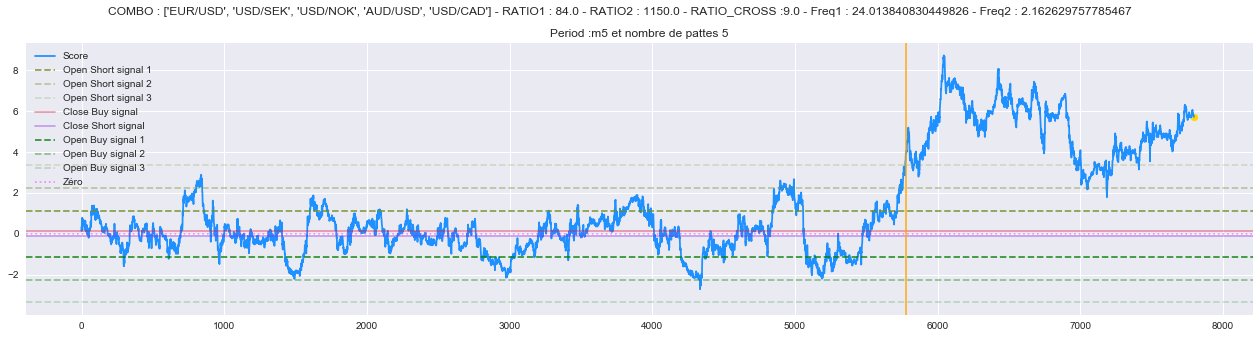

In [10]:
#for x in range(len(SL_PACK)):
DYNS = RESULTATS.get('DYNS')
lim_s1 = RESULTATS.get('lim_s1')
lim_s2 = RESULTATS.get('lim_s2')
lim_s3 = RESULTATS.get('lim_s3')
lim_l1 = RESULTATS.get('lim_l1')
lim_l2 = RESULTATS.get('lim_l2')
lim_l3 = RESULTATS.get('lim_l3')
lim_cl = 0.13
lim_cs = -0.13
TICKERS = RESULTATS.get('TICKERS')
_ratio1 = RESULTATS.get('_ratio1')
_ratio2 = RESULTATS.get('_ratio2')
_ratio_cross = RESULTATS.get('_ratio_cross')
_freq1 = RESULTATS.get('_freq1')
_freq2 = RESULTATS.get('_freq2')

print('COMBO',TICKERS,', type de DYNS',type(DYNS),' et longueur DYNS =',len(DYNS))
plt.ion() 
plt.figure(figsize=(22,5)) 
plt.plot(DYNS,label='Score',c='dodgerblue')
plt.scatter(x=len(DYNS),y=DYNS[-1],c='gold')
plt.axhline(y=lim_s1,c='olivedrab',alpha=0.8,linestyle='--',label='Open Short signal 1')
plt.axhline(y=lim_s2,c='olivedrab',alpha=0.4,linestyle='--',label='Open Short signal 2')
plt.axhline(y=lim_s3,c='olivedrab',alpha=0.2,linestyle='--',label='Open Short signal 3')
plt.axhline(y=lim_cl,c='crimson',alpha=0.4,linestyle='-',label='Close Buy signal')
plt.axhline(y=lim_cs,c='blueviolet',alpha=0.4,linestyle='-',label='Close Short signal')
plt.axhline(y=lim_l1,c='green',alpha=0.8,linestyle='--',label='Open Buy signal 1')
plt.axhline(y=lim_l2,c='green',alpha=0.4,linestyle='--',label='Open Buy signal 2')
plt.axhline(y=lim_l3,c='green',alpha=0.2,linestyle='--',label='Open Buy signal 3')
plt.axhline(y=(lim_cl+lim_cs)/2,c='magenta',alpha=0.4,linestyle=':',label='Zéro')
plt.axvline(x=train_length,c='orange',alpha=0.8)
plt.legend(loc='upper left')
plt.suptitle('COMBO : '+str(TICKERS)+' - RATIO1 : '+str(_ratio1)+' - RATIO2 : '+str(_ratio2)+' - RATIO_CROSS :'+str(_ratio_cross)+' - Freq1 : '+\
str(_freq1)+' - Freq2 : '+str(_freq2))
plt.title('Period :'+str(period)+' et nombre de pattes '+str(nb_pattes))
plt.pause(0.05)
    

In [38]:
D['period'] = period
D['nb_pattes'] = nb_pattes
D['PACK'] = PACK
D['_mean'] = _mean
D['_std'] = _std
D['S'] = S
D['coef'] = coef
D['residu'] = residu
D['deviamax'] = deviamax
D['combo'] = combo
D['daf'] = daf
D['cste'] = cste
D['lim_s1'] = lim_s1
D['lim_s2'] = lim_s2
D['lim_s3'] = lim_s3
D['lim_l1'] = lim_l1
D['lim_l2'] = lim_l2
D['lim_l3'] = lim_l3
D['_ratio1'] = _ratio1
D['_ratio2'] = _ratio2
D['_ratio_cross'] = _ratio_cross
D['_freq1'] = _freq1
D['_freq2'] = _freq2
D['amplitude'] = amplitude
D['TICKERS'] = TICKERS
D['DYNS'] = DYNS

9

COMBO None , type de DYNS <class 'list'>  et longueur DYNS = 7796
COMBO ['EUR/USD', 'USD/SEK', 'USD/NOK', 'AUD/USD', 'USD/CAD'] , type de DYNS <class 'list'>  et longueur DYNS = 7796


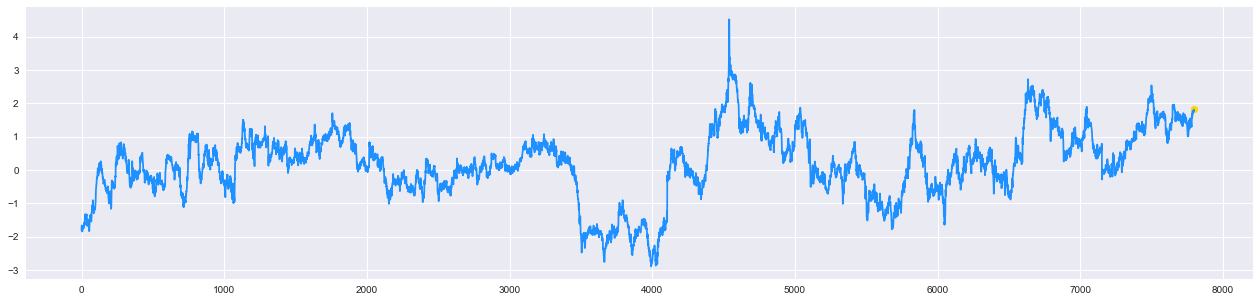

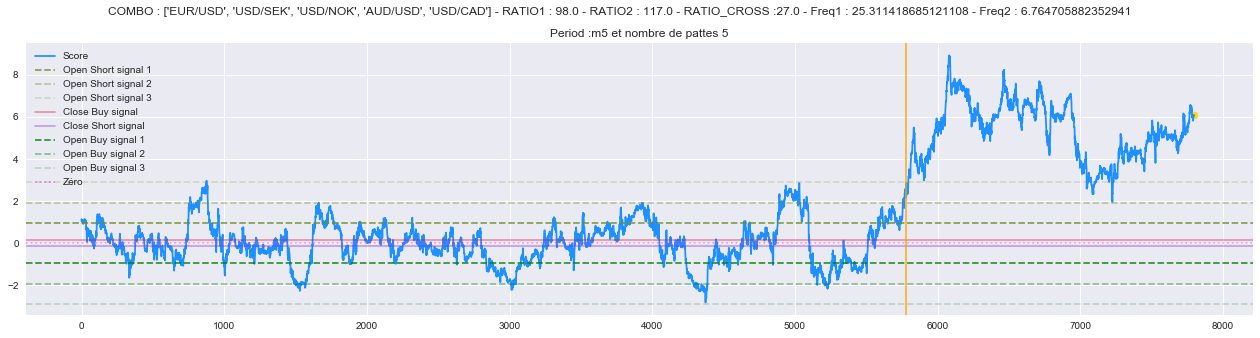

COMBO None , type de DYNS <class 'list'>  et longueur DYNS = 7796
COMBO None , type de DYNS <class 'list'>  et longueur DYNS = 7796
COMBO ['USD/SEK', 'EUR/USD', 'USD/NOK', 'AUD/USD', 'USD/CAD'] , type de DYNS <class 'list'>  et longueur DYNS = 7796


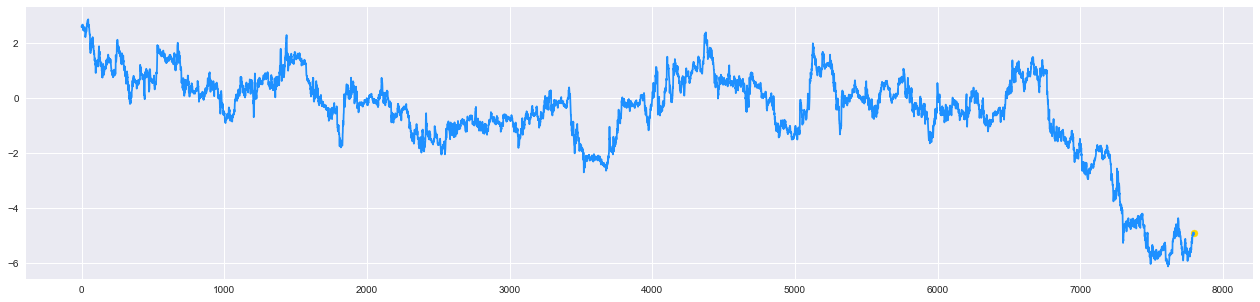

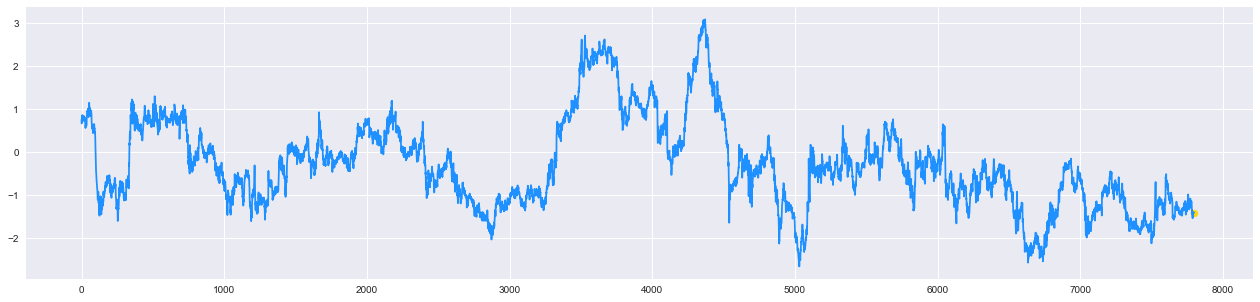

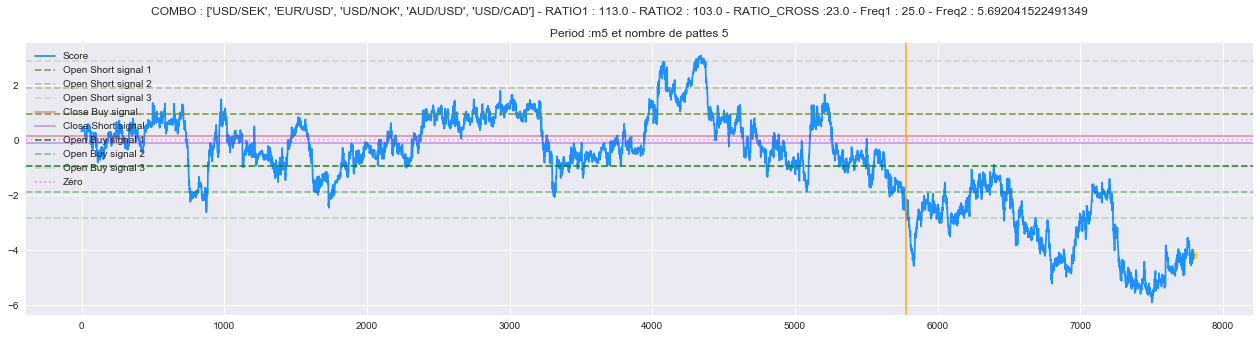

COMBO None , type de DYNS <class 'list'>  et longueur DYNS = 7796
COMBO None , type de DYNS <class 'list'>  et longueur DYNS = 9812


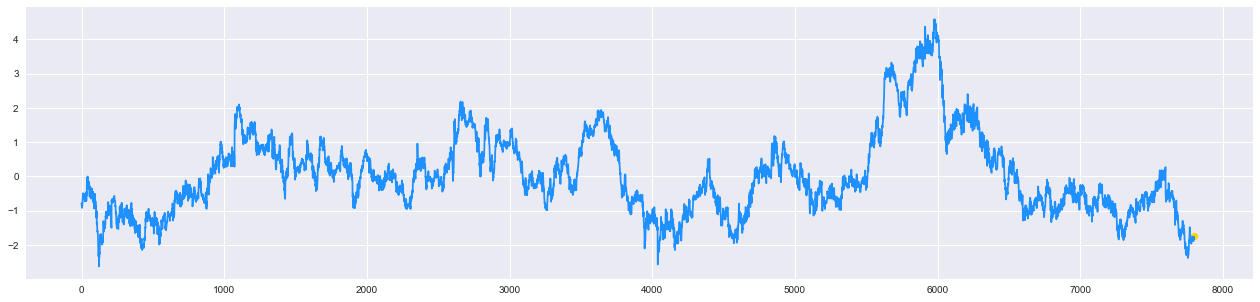

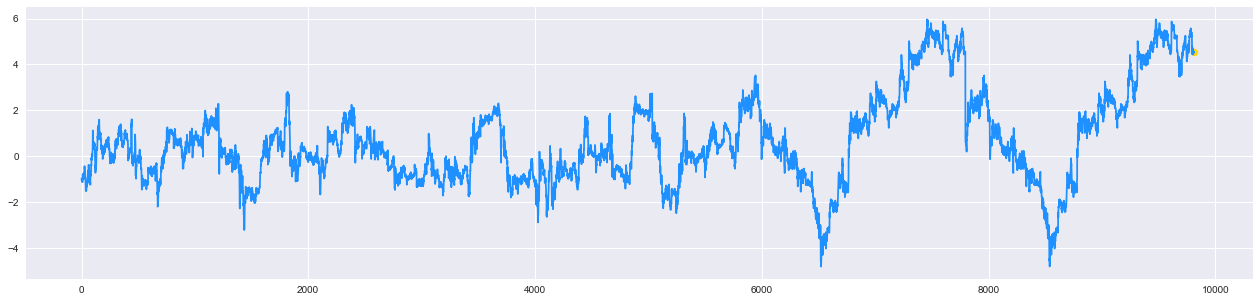

In [23]:
RESULTATS

{}

In [15]:
for x in range(len(SL_PACK)):
    print('TICKERS',SL_PACK[x][0]) # TICKERS
    print('_____________________________')
    print('mean',SL_PACK[x][1]) # _mean
    print('_____________________________')
    print('std',SL_PACK[x][2]) # _std
    print('_____________________________')
    print('S',SL_PACK[x][3]) # S
    print('_____________________________')
    print('coef',SL_PACK[x][4]) # coef
    print('_____________________________')
    print('residu',SL_PACK[x][5]) # residu
    print('_____________________________')
    print('combo',SL_PACK[x][6]) # combo
    print('_____________________________')
    print('daf',SL_PACK[x][7]) # daf
    print('_____________________________')
    print('cste',SL_PACK[x][8]) # cste
    print('_____________________________')
    print('lim_s1',SL_PACK[x][9]) # lim_s1
    print('_____________________________')
    print('lim_s2',SL_PACK[x][10]) # lim_s2
    print('_____________________________')
    print('lim_s3',(SL_PACK[x][11])) # lim_s3
    print('_____________________________')
    print('lim_l1',SL_PACK[x][12]) # lim_l1
    print('_____________________________')
    print('lim_l2',SL_PACK[x][13]) # lim_l2
    print('_____________________________')
    print('lim_l3',SL_PACK[x][14]) # lim_l3 
    print('_____________________________')
    print('ratio1',SL_PACK[x][15]) # _ratio1
    print('_____________________________')
    print('ratio2',SL_PACK[x][16]) # _ratio2
    print('_____________________________')
    print('ratio_cross',SL_PACK[x][17]) # _ratio_cross
    print('_____________________________')
    print('freq1',SL_PACK[x][18]) # freq1 ((up1 + down1)/len(S)) *100
    print('_____________________________')
    print('freq2',SL_PACK[x][19]) # freq2 ((up2 + down2)/len(S)) *100
    print('_____________________________')
    print('amplitude',SL_PACK[x][20]) # amplitude
    print('_____________________________')
    print('deviation',abs(SL_PACK[x][5].iloc[-1]/SL_PACK[x][2])) # DEVIATION => abs(DERNIER SPREAD/_std)
    print('_____________________________')
    print('slpack3',abs(SL_PACK[x][3].iloc[-1]))
    print('_____________________________')
    print('_____________________________')
    print('_____________________________')
    print('_____________________________')

TICKERS ['USD/CAD', 'AUD/USD', 'NZD/USD']
_____________________________
mean -6.119672243003026e-17
_____________________________
std 0.0016598330273488366
_____________________________
S 0       1.605562
1       1.181326
2       1.242535
3       1.249656
4       1.514113
          ...   
5775   -0.658120
5776   -0.412577
5777   -0.556110
5778   -0.578088
5779   -0.585391
Length: 5780, dtype: float64
_____________________________
coef [0.56416185 0.18703931]
_____________________________
residu 0       0.002665
1       0.001961
2       0.002062
3       0.002074
4       0.002513
          ...   
5775   -0.001092
5776   -0.000685
5777   -0.000923
5778   -0.000960
5779   -0.000972
Length: 5780, dtype: float64
_____________________________
combo 0       0.714148
1       0.714667
2       0.714660
3       0.714371
4       0.714276
          ...   
5775    0.742204
5776    0.741645
5777    0.741974
5778    0.742447
5779    0.741904
Length: 5780, dtype: float64
_____________________________
da